#### <b>Review:</b>

This notebook is part of the series of 3 notebooks attempting to demonstrate and record the half-year work contributed to my final thesis project in the Master of Data Science degree, which aimed to test the feedback interactions between wildfire occurrences and local weather changes in day-to-month time scales, through applications of deep learning models on remote sensing data (satellite image time series and grid-point numerical weather observation time series).

Being the sequel of the research settings, data collection, feature processing and engineering in Part I notebook, this notebook would be introducing the machine learning models built and the training results upon different experimental scenarios. The below flow chart conceptualizes the fundamental structure of the neural network.

There are several features for this model: 1) multi-channel inputs, where the grid-specific features and surrounding atmoshperic features would be inputted according to daily and monthly prediction settings; 2) bi-directional convolutional long-short term memory network (BiConvLSTM) encoded the spatio-temporal features into latent embeddings; 3) multi-head attention layer with 6 to 8 heads mapping to the 3 axes (temporal lags, spatial height and spatial width of the partitioned sub-grids); 4) deconvolution layer to decode the fire image maps at next time step.

<br>

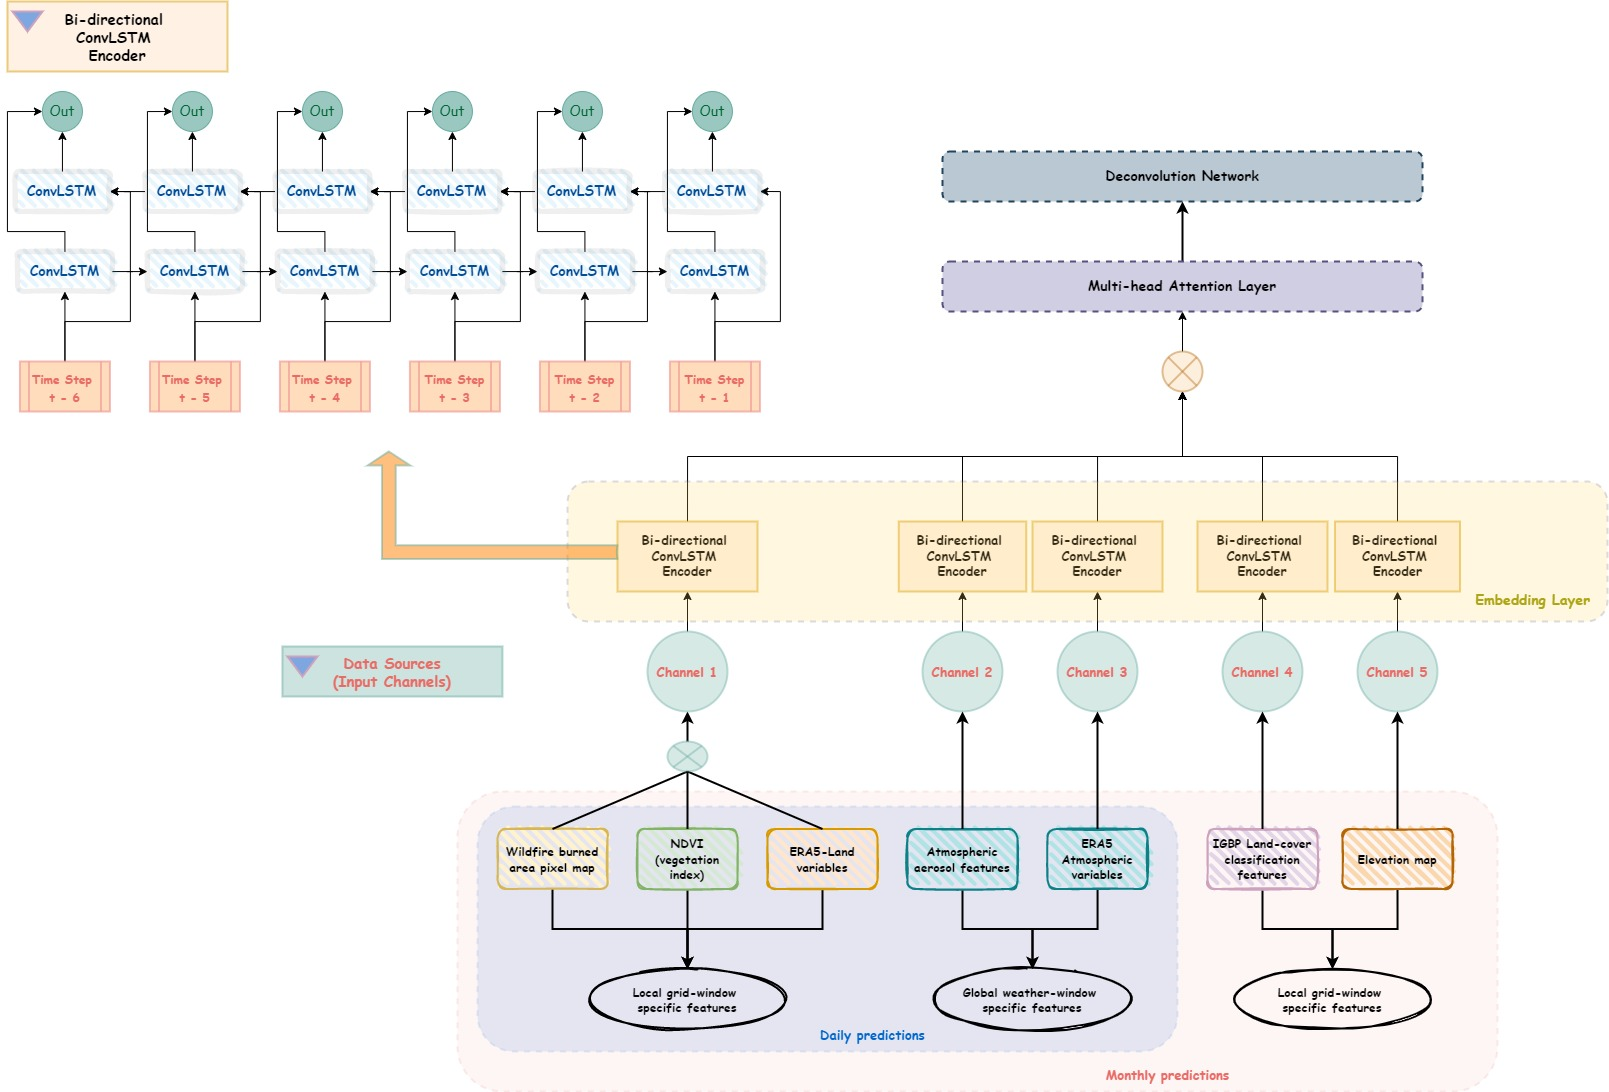

In [3]:
from IPython.display import Image
Image("F'/content/drive/MyDrive/Model_vis.jpg")

In [ ]:
from bi_convlstm_attention_cnn.model import BiConvLSTM_Attention_Model
from bi_convlstm_attention_cnn.model import *
import tensorflow as tf
import numpy as np

In [ ]:
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 0})
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config = config)

In [ ]:
## grids with higher proportion of occurrences of fire
selected_grids_daily = [0,1,2,3,4,6,10,13,16]
selected_grids_monthly = [0,10,16,18,19]

In [ ]:
## Train-Test Splits
import random
random.seed(123)

In [ ]:
## Daily splitting  (Fire Seasons)
## selecting images with only positive occurrences
grid_select_chain = []
for g in range(selected_grids_daily):
    grid_selected_time = []
    for t in range(183 * 3):
        if np.max(y_wf[g][t]) != 0:
            grid_selected_time.append(t)
    grid_select_chain.append(grid_selected_time)
    
## 80% training; 10% validation; 10% testing
train_index = [random.sample(grid_select_chain[x], int(len(grid_select_chain[x]) * 0.8)) for x in range(len(selected_grids_daily))]
nontrain_index = [[y for y in grid_select_chain[x] if y not in train_index[x]] for x in range(len(selected_grids_daily))]
val_index = [random.sample(nontrain_index[x], int(len(nontrain_index[x]) * 0.5)) for x in range(len(selected_grids_daily))]
test_index = [[y for y in nontrain_index[x] if y not in val_index[x]] for x in range(len(selected_grids_daily))]

train_x = [grid_features[train_index], 
           np.concatenate(tuple([era5_daily_scaled[fire_season_index]] * 5), axis=0)[train_index], 
           np.concatenate(tuple([aerosol_daily_scaled[fire_season_index]] * 5), axis=0)[train_index]]
val_x = [grid_features[val_index], 
         np.concatenate(tuple([era5_daily_scaled[fire_season_index]] * 5), axis=0)[val_index], 
         np.concatenate(tuple([aerosol_daily_scaled[fire_season_index]] * 5), axis=0)[val_index]]
test_x = [grid_features[test_index], 
          np.concatenate(tuple([era5_daily_scaled[fire_season_index]] * 5), axis=0)[test_index], 
          np.concatenate(tuple([aerosol_daily_scaled[fire_season_index]] * 5), axis=0)[test_index]]

In [ ]:
## Daily splitting  (Weather Forecast Intervals)
## 80% training; 10% validation; 10% testing
train_index = [random.sample(grid_select_chain[x], int(len(grid_select_chain[x]) * 0.8)) for x in range(len(selected_grids_daily))]
nontrain_index = [[y for y in grid_select_chain[x] if y not in train_index[x]] for x in range(len(selected_grids_daily))]
val_index = [random.sample(nontrain_index[x], int(len(nontrain_index[x]) * 0.5)) for x in range(len(selected_grids_daily))]
test_index = [[y for y in nontrain_index[x] if y not in val_index[x]] for x in range(len(selected_grids_daily))]

train_x = [grid_features[train_index], 
           np.concatenate(tuple([era5_daily_scaled[weather_period_index]] * 5), axis=0)[train_index], 
           np.concatenate(tuple([aerosol_daily_scaled[weather_period_index]] * 5), axis=0)[train_index]]
val_x = [grid_features[val_index], 
         np.concatenate(tuple([era5_daily_scaled[weather_period_index]] * 5), axis=0)[val_index], 
         np.concatenate(tuple([aerosol_daily_scaled[weather_period_index]] * 5), axis=0)[val_index]]
test_x = [grid_features[test_index], 
          np.concatenate(tuple([era5_daily_scaled[weather_period_index]] * 5), axis=0)[test_index], 
          np.concatenate(tuple([aerosol_daily_scaled[weather_period_index]] * 5), axis=0)[test_index]]

In [ ]:
## Monthly splitting  (Fire Seasons)
## long-term prediction addition features
land_cover = np.array([x for i in range(6) for x in LC])
land_cover = land_cover.astype(np.uint8)
land_cover = land_cover / 255.0
elev = np.array([elevation[selected_grids_monthly[g]] for x in range(6 * 9)]).reshape(6 * 9, 280, 280, 3)
elev = elev / 255.0
## 210 training; 30 validation; 30 testing
train_index = np.r_[0:42,54:96,108:150,162:204,216:258]
val_index = np.r_[42:48,96:102,150:156,204:210,258:264]
test_index = np.r_[48:54,102:108,156:162,210:216,264:270]
## Time series splitting
train_x = [grid_features[train_index], 
           np.concatenate(tuple([era5_monthly_scaled[fire_season_index]] * 5), axis=0)[train_index], 
           np.concatenate(tuple([aerosol_monthly_scaled[fire_season_index]] * 5), axis=0)[train_index],
           land_cover[train_index],
           elev[train_index]]
val_x = [grid_features[val_index], 
         np.concatenate(tuple([era5_monthly_scaled[fire_season_index]] * 5), axis=0)[val_index], 
         np.concatenate(tuple([aerosol_monthly_scaled[fire_season_index]] * 5), axis=0)[val_index],
         land_cover[val_index],
         elev[val_index]]
test_x = [grid_features[test_index], 
          np.concatenate(tuple([era5_monthly_scaled[fire_season_index]] * 5), axis=0)[test_index], 
          np.concatenate(tuple([aerosol_monthly_scaled[fire_season_index]] * 5), axis=0)[test_index],
          land_cover[test_index],
          elev[test_index]]

In [ ]:
## Monthly splitting  (Weather Forecast Intervals)
## long-term prediction addition features
land_cover = np.array([x for i in range(8) for x in LC])
land_cover = land_cover.astype(np.uint8)
land_cover = land_cover / 255.0
elev = np.array([elevation[selected_grids_monthly[g]] for x in range(8 * 9)]).reshape(8 * 9, 280, 280, 3)
elev = elev / 255.0
## 280 training; 40 validation; 40 testing
train_index = np.r_[0:56,72:128,144:200,216:272,288:344]
val_index = np.r_[56:64,128:136,200:208,272:280,344:352]
test_index = np.r_[64:72,136:144,208:216,280:288,352:360]
## Time series splitting
train_x = [grid_features[train_index], 
           np.concatenate(tuple([era5_monthly_scaled[weather_period_index]] * 5), axis=0)[train_index], 
           np.concatenate(tuple([aerosol_monthly_scaled[weather_period_index]] * 5), axis=0)[train_index],
           land_cover[train_index],
           elev[train_index]]
val_x = [grid_features[val_index], 
         np.concatenate(tuple([era5_monthly_scaled[weather_period_index]] * 5), axis=0)[val_index], 
         np.concatenate(tuple([aerosol_monthly_scaled[weather_period_index]] * 5), axis=0)[val_index],
         land_cover[val_index],
         elev[val_index]]
test_x = [grid_features[test_index], 
          np.concatenate(tuple([era5_monthly_scaled[weather_period_index]] * 5), axis=0)[test_index], 
          np.concatenate(tuple([aerosol_monthly_scaled[weather_period_index]] * 5), axis=0)[test_index],
          land_cover[test_index],
          elev[test_index]]

In [ ]:
## Event model example
event_monthly = BiConvLSTM_Attention_Model(
                                        mode="monthly", img_height=1120, img_width=1120, 
                                        output_img_height=56, output_img_width=56, 
                                        lag_window=6, neighbour_window=5,
                                        land_grid_height=50, land_grid_width=50, land_grid_features=114,
                                        weather_window_height=50, weather_window_width=40
                                        )
event_monthly_model = event_monthly.get_model(num_encoder_layers = 5, 
                                              num_decoder_layers = 4,
                                              fixed_decoder_intermediate = False)

In [ ]:
event_monthly_model.summary(line_length=150)

Model: "model_1"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_25 (InputLayer)                           [(None, None, 50, 50, 570)]      0                 []                                                
                                                                                                                                                      
 bidirectional_48 (Bidirectional)                (None, None, 50, 50, 256)        17869824          ['input_25[0][0]']                                
                                                                                                                                                      
 batch_normalization_52 (BatchNormalization)     (None, None, 50, 50, 256)   

In [ ]:
## Scalar Weather Observation model example
scalar_monthly = BiConvLSTM_Attention_Model(
                                            mode="monthly", img_height=1120, img_width=1120, 
                                            lag_window=8, neighbour_window=5,
                                            land_grid_height=50, land_grid_width=50, land_grid_features=114,
                                            weather_window_height=50, weather_window_width=40
                                            )
scalar_monthly_model = scalar_monthly.get_model(num_encoder_layers = 5, 
                                                num_decoder_layers = 4,
                                                fixed_decoder_intermediate = True)

In [ ]:
scalar_monthly_model.summary(line_length=150)

Model: "model_2"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_33 (InputLayer)                           [(None, None, 50, 50, 570)]      0                 []                                                
                                                                                                                                                      
 bidirectional_64 (Bidirectional)                (None, None, 50, 50, 256)        17869824          ['input_33[0][0]']                                
                                                                                                                                                      
 batch_normalization_71 (BatchNormalization)     (None, None, 50, 50, 256)   

#### 5.1) Deep Learning Models (Wildfire Event Prediction):

For better training, 9 grids with more abundant fire pixels were selected for the short-term prediction (daily), and in the same case, 5 grids were selected for long-term prediction (monthly).

For daily wildfire pixelwise burned area classification, training individually on 9 grids, generally it could achieve 70% - 90% precision and recall (on positive class of fire pixels), with accuracy attaining over 90%. Particularly the first two grids had almost perfect training performance. Yet, overfitting was observed when testing the performance on the 10% testing data after fitting 100 epochs, mainly affected by the lowered precision. The testing recall of those grids mainly fell between 40% to 70% with precision in range of around 45% to 55%. In the past research of this domain, a major problem was the model could either be making a good precision or a good recall but cannot easily achieve both to have a high F1-score, a trade-off hence exists between the two objectives of maximizing precision (few false alarms while higher risk of missing many fires) and maximizing recall (capturing large propotions of fire occurrences while making wasteful resource allocation due to relatively lower precision in guess). 

From the table below illustrating the variations of testing results on the 9 grids below, it could be seen that if one grid has smaller percentages of wildfire pixels, it could achieve a higher accuracy (higher probability / tendency learnt to predict the dominating negative class), but the F1-score would be lower than those grids with a higher proportion of positive pixels. Better effects might be seen for fine-tuning parameters like the number of encoder and decoder layers individually for the model of each single grid, the model class object provides options to specify these self-defined settings to serve like an Auto-ML functionality.

For monthly prediction of burned areas, training was done on all grids because the number of samples (time points in the time series) of each grid would be too few for inferencing. The general recall rate maintained at around 20% to 25%, and the precision was relatively high lying between 55% to 70%, the overall accuracy was around 65% among the 5 grids. This means long term wildfire spreading would be quite difficult to predict given a large variation accumulated across months in active fire seasons, while per-day changes would be limited and could be sucessfully detected.

Daily Predictions (Precision, Recall and F1-score based on positive class - wildfire occurrences)


<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="4">Training Set</th>
      <th colspan="4">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires (Positive Pixels)</th>
      <th>precision</th>	
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
      <th>precision</th>
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>26.57%</td>
      <td>0.97</td>
      <td>0.96</td>
      <td>0.96</td>
      <td>0.98</td>
      <td>0.56</td>
      <td>0.41</td>
      <td>0.47</td>
      <td>0.76</td>
    </tr>
    <tr>
      <td>1</td>
      <td>22.45%</td>
      <td>0.90</td>
      <td>0.95</td>
      <td>0.93</td>
      <td>0.97</td>
      <td>0.56</td>
      <td>0.56</td>
      <td>0.56</td>
      <td>0.82</td>
    </tr>
    <tr>
      <td>2</td>
      <td>12.82%</td>
      <td>0.71</td>
      <td>0.84</td>
      <td>0.77</td>
      <td>0.94</td>
      <td>0.32</td>
      <td>0.43</td>
      <td>0.37</td>
      <td>0.83</td>
    </tr>
    <tr>
      <td>3</td>
      <td>11.79%</td>
      <td>0.84</td>
      <td>0.76</td>
      <td>0.80</td>
      <td>0.95</td>
      <td>0.34</td>
      <td>0.27</td>
      <td>0.30</td>
      <td>0.86</td>
    </tr>
    <tr>
      <td>4</td>
      <td>19.90%</td>
      <td>0.71</td>
      <td>0.82</td>
      <td>0.76</td>
      <td>0.90</td>
      <td>0.45</td>
      <td>0.49</td>
      <td>0.47</td>
      <td>0.77</td>
    </tr>
    <tr>
      <td>6</td>
      <td>17.53%</td>
      <td>0.82</td>
      <td>0.73</td>
      <td>0.78</td>
      <td>0.93</td>
      <td>0.44</td>
      <td>0.39</td>
      <td>0.41</td>
      <td>0.81</td>
    </tr>
    <tr>
      <td>10</td>
      <td>24.98%</td>
      <td>0.87</td>
      <td>0.91</td>
      <td>0.89</td>
      <td>0.94</td>
      <td>0.48</td>
      <td>0.57</td>
      <td>0.52</td>
      <td>0.77</td>
    </tr>
    <tr>
      <td>13</td>
      <td>16.22%</td>
      <td>0.87</td>
      <td>0.70</td>
      <td>0.78</td>
      <td>0.93</td>
      <td>0.48</td>
      <td>0.36</td>
      <td>0.41</td>
      <td>0.85</td>
    </tr>
    <tr>
      <td>16</td>
      <td>25.89%</td>
      <td>0.86</td>
      <td>0.66</td>
      <td>0.75</td>
      <td>0.88</td>
      <td>0.54</td>
      <td>0.46</td>
      <td>0.50</td>
      <td>0.78</td>
    </tr>
  </tbody>
</table>

Monthly Predictions (Precision, Recall and F1-score based on positive class - wildfire occurrences)


<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="4">Training Set</th>
      <th colspan="4">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires (Positive Pixels)</th>
      <th>precision</th>	
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
      <th>precision</th>
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>11.43%</td>
      <td>0.46</td>
      <td>0.18</td>
      <td>0.26</td>
      <td>0.74</td>
      <td>0.32</td>
      <td>0.30</td>
      <td>0.31</td>
      <td>0.68</td>
    </tr>
    <tr>
      <td>10</td>
      <td>10.45%</td>
      <td>0.69</td>
      <td>0.18</td>
      <td>0.28</td>
      <td>0.67</td>
      <td>0.57</td>
      <td>0.27</td>
      <td>0.37</td>
      <td>0.66</td>
    </tr>
    <tr>
      <td>16</td>
      <td>14.29%</td>
      <td>0.79</td>
      <td>0.21</td>
      <td>0.33</td>
      <td>0.57</td>
      <td>0.67</td>
      <td>0.26</td>
      <td>0.38</td>
      <td>0.56</td>
    </tr>
    <tr>
      <td>18</td>
      <td>11.80%</td>
      <td>0.72</td>
      <td>0.22</td>
      <td>0.34</td>
      <td>0.80</td>
      <td>0.71</td>
      <td>0.28</td>
      <td>0.40</td>
      <td>0.70</td>
    </tr>
    <tr>
      <td>19</td>
      <td>13.69%</td>
      <td>0.75</td>
      <td>0.25</td>
      <td>0.37</td>
      <td>0.67</td>
      <td>0.55</td>
      <td>0.29</td>
      <td>0.38</td>
      <td>0.66</td>
    </tr>
  </tbody>
</table>

In [ ]:
##  Predictive Task 1):  wildfire burned pixel classification

## For daily, given larger number of samples per grid, one model would be sepcified for each grid
wf_daily = []
for grid in range(len(selected_grids_daily)):
    grid_wf_daily = BiConvLSTM_Attention_Model_Events(
                        mode="daily", img_height=560, img_width=560, 
                        output_img_height=7, output_img_width=7, 
                        lag_window=8, neighbour_window=5,
                        land_grid_height=50, land_grid_width=50, land_grid_features=114,
                        weather_window_height=50, weather_window_width=40)
    wf_daily.append(grid_wf_daily)

## For monthly, given smaller number of samples per grid, one model would be sepcified for all grids
wf_monthly = BiConvLSTM_Attention_Model_Events(
                        mode="monthly", img_height=1120, img_width=1120, 
                        output_img_height=56, output_img_width=56, 
                        lag_window=6, neighbour_window=5,
                        land_grid_height=50, land_grid_width=50, land_grid_features=114,
                        weather_window_height=50, weather_window_width=40)

In [ ]:
## training and predictions
wf_daily_model = []
pred_train = []
pred_test = []

for grid in range(len(selected_grids_daily)):
    ## load daily "wildfire" target array file from folder path at this point
    data_y = y_wf[grid]
    train_y = data_y[train_index[grid]]
    val_y = data_y[val_index[grid]]
    test_y = data_y[test_index[grid]]

    model = wf_daily[grid].get_model(num_encoder_layers = 5, num_decoder_layers = 4)
    model.compile(loss = "binary_crossentropy", 
                  optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                  metrics = ['Accuracy','TruePositives','Precision'])
    model.fit(train_x, train_y, epochs=100, batch_size=4,
              validation_data = (val_x, val_y),
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])
    wf_daily_model.append(model)

    pred_train.append([train_y, wf_daily_model[grid].predict(train_x, batch_size = 4)])
    pred_test.append([test_y, wf_daily_model[grid].predict(test_x, batch_size = 4)])

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_train[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_train[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5562
           1       0.97      0.96      0.96      2013

    accuracy                           0.98      7575
   macro avg       0.98      0.98      0.98      7575
weighted avg       0.98      0.98      0.98      7575



              precision    recall  f1-score   support

           0       0.98      0.97      0.98      7096
           1       0.90      0.95      0.93      2054

    accuracy                           0.97      9150
   macro avg       0.94      0.96      0.95      9150
weighted avg       0.97      0.97      0.97      9150



              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5340
           1       0.71      0.84      0.77       785

    accuracy                           0.94      6125
   macro avg       0.84      0.90      0.87      6125
weighted avg       0.94      0.94      0.94      6125



             

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_test[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_test[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       995
           1       0.56      0.41      0.47       355

    accuracy                           0.76      1350
   macro avg       0.68      0.65      0.66      1350
weighted avg       0.74      0.76      0.75      1350



              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1294
           1       0.56      0.56      0.56       331

    accuracy                           0.82      1625
   macro avg       0.72      0.72      0.72      1625
weighted avg       0.82      0.82      0.82      1625



              precision    recall  f1-score   support

           0       0.92      0.88      0.90       974
           1       0.32      0.43      0.37       126

    accuracy                           0.83      1100
   macro avg       0.62      0.66      0.64      1100
weighted avg       0.85      0.83      0.84      1100



             

In [ ]:
## training and predictions
pred_train = []
pred_test = []

## load monthly "wildfire" target array file from folder path at this point
data_y = y_wf[selected_grids_monthly]
train_y = data_y[[train_index[grid] for grid in selected_grids_monthly]]
val_y = data_y[[val_index[grid] for grid in selected_grids_monthly]]
test_y = data_y[[test_index[grid] for grid in selected_grids_monthly]]

wf_monthly_model = wf_monthly.get_model(num_encoder_layers = 5, num_decoder_layers = 4)
wf_monthly_model.compile(loss = "binary_crossentropy", 
                         optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                         metrics = ['Accuracy','TruePositives','Precision'])
wf_monthly_model.fit(train_x, train_y, epochs=100, batch_size=4,
                      validation_data = (val_x, val_y),
                      callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)])

pred_train.append([train_y, wf_monthly_model.predict(train_x, batch_size = 4)])
pred_test.append([test_y, wf_monthly_model.predict(test_x, batch_size = 4)])

In [ ]:
y_pred = copy.deepcopy(pred_train.reshape(1, -1))
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
print(classification_report([str(int(x)) for x in y_pred.tolist()[0]], 
                            [str(int(x)) for x in train_y.reshape(1, -1).tolist()[0]]))

              precision    recall  f1-score   support

           0       0.67      0.94      0.78    472391
           1       0.67      0.21      0.32    280249

    accuracy                           0.67    752640
   macro avg       0.67      0.57      0.55    752640
weighted avg       0.67      0.67      0.61    752640



In [ ]:
for n in range(len(selected_grids_monthly)):
    y_pred = copy.deepcopy(pred_train[n].reshape(1, -1))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    print(classification_report([str(int(x)) for x in y_pred.tolist()[0]], 
                                [str(int(x)) for x in train_y[n].reshape(1, -1).tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.77      0.93      0.84    111945
           1       0.46      0.18      0.26     38583

    accuracy                           0.74    150528
   macro avg       0.61      0.55      0.55    150528
weighted avg       0.69      0.74      0.69    150528



              precision    recall  f1-score   support

           0       0.66      0.95      0.78     94647
           1       0.69      0.18      0.28     55881

    accuracy                           0.67    150528
   macro avg       0.68      0.57      0.53    150528
weighted avg       0.67      0.67      0.60    150528



              precision    recall  f1-score   support

           0       0.54      0.94      0.69     74641
           1       0.79      0.21      0.33     75887

    accuracy                           0.57    150528
   macro avg       0.66      0.58      0.51    150528
weighted avg       0.66      0.57      0.51    150528



             

In [ ]:
y_pred = copy.deepcopy(pred_test.reshape(1, -1))
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
print(classification_report([str(int(x)) for x in y_pred.tolist()[0]], 
                            [str(int(x)) for x in test_y.reshape(1, -1).tolist()[0]]))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76     59978
           1       0.53      0.27      0.36     34102

    accuracy                           0.65     94080
   macro avg       0.60      0.57      0.56     94080
weighted avg       0.62      0.65      0.61     94080



In [ ]:
for n in range(len(selected_grids_monthly)):
    y_pred = copy.deepcopy(pred_test[n].reshape(1, -1))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    print(classification_report([str(int(x)) for x in y_pred.tolist()[0]], 
                                [str(int(x)) for x in test_y[n].reshape(1, -1).tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     14315
           1       0.32      0.30      0.31      4501

    accuracy                           0.68     18816
   macro avg       0.55      0.55      0.55     18816
weighted avg       0.67      0.68      0.68     18816



              precision    recall  f1-score   support

           0       0.68      0.88      0.77     11969
           1       0.57      0.27      0.37      6847

    accuracy                           0.66     18816
   macro avg       0.62      0.58      0.57     18816
weighted avg       0.64      0.66      0.62     18816



              precision    recall  f1-score   support

           0       0.54      0.87      0.66      9323
           1       0.67      0.26      0.38      9493

    accuracy                           0.56     18816
   macro avg       0.60      0.57      0.52     18816
weighted avg       0.60      0.56      0.52     18816



             

#### 5.2) Deep Learning Models (Temperature Forecast - mean, max, min)

For assessing the impacts of wildfire occurrences on weather patterns, as said, two sets of results could be generated with existence or absence of the wildfire image time series features in the BiConvLSTM encoders. Below demonstrates the modelling based on the targets on the mean temperature, and the extremes of temperature (maximum and minimum) for the daily interval, and the monthly average temperature in capturing the long-term trend. For models without wildfire features, 1 layer of BiConvLSTM was deployed for the feature encoder, against 3 layers of BiConvLSTM layers being tested when wildfire features were included.

For daily predictions, 4 grids out of 9 had shown improvements on predicting the next-day mean temperature given the inputs of wildfire features; while for extremes, 5 grids got improved on predicting the maximum temperature, and 7 grids got improved on predicting the minimum temperature. It might mean the variations contributed by fire features were more sensitive to the lower bound of temperature than the mean or maximum. Since an 8-day lag was being considered, this might also validate the short-term local cooling effects soon after the fire events in a few days, which were more frequently seen over the 9 grids of the investigated region. Plots the predicted values against actual values for each of the 9 grids based on the model with 3-layer BiConvLSTM for encoding (fire features included), and most generally indicate a good fit close to the linear relationship. 

Some grids might have larger errors like grid index 1 and 13, which might be providing insights for scientific investigations on the local geographical or anthropogenic factors. The error range in most case achieved 0.50 to 2.00 degree Kelvins, somehow for some of the areas it was more accurate than the others, which might hint that fine tuning models individually adapting to local contexts could be explored instead of using the same setting in this demonstration, like changining the values of parameters in the AutoML-like model class objects.

For monthly predictions, the overfitting problem was much milder in general. The reduction in the prediction errors with the existence of wildfire features was less significant than it did for the daily contexts. It might also be due to the fact that only large-scale, widespreading and long-lasting were relatively rare and the averaged temperature would be less sensitive to the changes to impacts brought by fire spots. Nevertheless, the magnitude of errors evaluated on the 5 grids was generally smaller than 1 degree Kelvin. 

Daily Predictions

** N.I. = No Improvement


<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="9">With no wildfire image features (Testing Set)</th>
      <th colspan="9">With existence of wildfire features (Testing Set)</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3">Mean Temperature</th>
      <th colspan="3">Max Temperature</th>
      <th colspan="3">Min Temperature</th>
      <th colspan="3">Mean Temperature</th>
      <th colspan="3">Max Temperature</th>
      <th colspan="3">Min Temperature</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires (Positive Pixels)</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>26.57%</td>
      <td>2.03</td>
      <td>0.66%</td>
      <td>0.78</td>
      <td>2.90</td>
      <td>0.96%</td>
      <td>0.61</td>
      <td>2.05</td>
      <td>0.71%</td>
      <td>0.77</td>
      <td>1.30</td>
      <td>0.44%</td>
      <td>0.91</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>1</td>
      <td>22.45%</td>
      <td>8.21</td>
      <td>2.75%</td>
      <td>-2.89</td>
      <td>4.90</td>
      <td>1.62%</td>
      <td>-0.36</td>
      <td>3.14</td>
      <td>1.07%</td>
      <td>0.24</td>
      <td>2.67</td>
      <td>0.89%</td>
      <td>0.50</td>
      <td>3.07</td>
      <td>1.10%</td>
      <td>0.49</td>
      <td>1.99</td>
      <td>0.67%</td>
      <td>0.64</td>
    </tr>
    <tr>
      <td>2</td>
      <td>12.82%</td>
      <td>1.72</td>
      <td>0.58%</td>
      <td>0.79</td>
      <td>2.05</td>
      <td>0.69%</td>
      <td>0.71</td>
      <td>2.24</td>
      <td>0.77%</td>
      <td>0.64</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>1.94</td>
      <td>0.67%</td>
      <td>0.72</td>
    </tr>
    <tr>
      <td>3</td>
      <td>11.79%</td>
      <td>1.18</td>
      <td>0.40%</td>
      <td>0.79</td>
      <td>1.91</td>
      <td>0.62%</td>
      <td>0.60</td>
      <td>1.96</td>
      <td>0.67%</td>
      <td>0.53</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>1.84</td>
      <td>0.60%</td>
      <td>0.64</td>
      <td>1.53</td>
      <td>0.51%</td>
      <td>0.67</td>
    </tr>
    <tr>
      <td>4</td>
      <td>19.90%</td>
      <td>3.19</td>
      <td>1.07%</td>
      <td>-0.82</td>
      <td>1.86</td>
      <td>0.61%</td>
      <td>0.35</td>
      <td>3.41</td>
      <td>1.15%</td>
      <td>-0.77</td>
      <td>1.21</td>
      <td>0.40%</td>
      <td>0.65</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>0.92</td>
      <td>0.31%</td>
      <td>0.82</td>
    </tr>
    <tr>
      <td>6</td>
      <td>17.53%</td>
      <td>0.87</td>
      <td>0.29%</td>
      <td>0.77</td>
      <td>1.88</td>
      <td>0.61%</td>
      <td>0.35</td>
      <td>1.47</td>
      <td>0.50%</td>
      <td>0.43</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>1.14</td>
      <td>0.37%</td>
      <td>0.70</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>10</td>
      <td>24.98%</td>
      <td>2.38</td>
      <td>0.80%</td>
      <td>0.08</td>
      <td>1.63</td>
      <td>0.54%</td>
      <td>0.47</td>
      <td>1.18</td>
      <td>0.40%</td>
      <td>0.72</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>0.84</td>
      <td>0.29%</td>
      <td>0.81</td>
    </tr>
    <tr>
      <td>13</td>
      <td>16.22%</td>
      <td>0.85</td>
      <td>0.28%</td>
      <td>0.82</td>
      <td>3.07</td>
      <td>1.00%</td>
      <td>-0.46</td>
      <td>4.41</td>
      <td>1.50%</td>
      <td>-2.04</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>2.24</td>
      <td>0.74%</td>
      <td>0.18</td>
      <td>1.19</td>
      <td>0.41%</td>
      <td>0.68</td>
    </tr>
    <tr>
      <td>16</td>
      <td>25.89%</td>
      <td>1.71</td>
      <td>0.57%</td>
      <td>-0.13</td>
      <td>1.26</td>
      <td>0.41%</td>
      <td>0.52</td>
      <td>1.13</td>
      <td>0.38%</td>
      <td>0.21</td>
      <td>1.15</td>
      <td>0.38%</td>
      <td>0.33</td>
      <td>0.84</td>
      <td>0.27%</td>
      <td>0.73</td>
      <td>0.80</td>
      <td>0.27%</td>
      <td>0.57</td>
    </tr>
  </tbody>
</table>

Monthly Predictions

<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="6">With no wildfire image features</th>
      <th colspan="6">With existence of wildfire image features</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires (Positive Pixels)</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>11.43%</td>
      <td>1.08</td>
      <td>0.37%</td>
      <td>0.87</td>
      <td>1.21</td>
      <td>0.41%</td>
      <td>0.80</td>
      <td>0.82</td>
      <td>0.28%</td>
      <td>0.93</td>
      <td>1.00</td>
      <td>0.34%</td>
      <td>0.87</td>
    </tr>
    <tr>
      <td>10</td>
      <td>10.45%</td>
      <td>0.66</td>
      <td>0.22%</td>
      <td>0.74</td>
      <td>0.66</td>
      <td>0.22%</td>
      <td>0.58</td>
      <td>0.54</td>
      <td>0.18%</td>
      <td>0.82</td>
      <td>0.64</td>
      <td>0.21%</td>
      <td>0.64</td>
    </tr>
    <tr>
      <td>16</td>
      <td>14.29%</td>
      <td>0.56</td>
      <td>0.19%</td>
      <td>0.79</td>
      <td>0.61</td>
      <td>0.20%</td>
      <td>0.62</td>
      <td>0.50</td>
      <td>0.17%</td>
      <td>0.83</td>
      <td>0.54</td>
      <td>0.18%</td>
      <td>0.68</td>
    </tr>
    <tr>
      <td>18</td>
      <td>11.80%</td>
      <td>0.73</td>
      <td>0.24%</td>
      <td>0.67</td>
      <td>0.79</td>
      <td>0.26%</td>
      <td>0.52</td>
      <td>0.58</td>
      <td>0.19%</td>
      <td>0.78</td>
      <td>0.77</td>
      <td>0.26%</td>
      <td>0.53</td>
    </tr>
    <tr>
      <td>19</td>
      <td>13.69%</td>
      <td>0.52</td>
      <td>0.17%</td>
      <td>0.83</td>
      <td>0.54</td>
      <td>0.18%</td>
      <td>0.77</td>
      <td>0.49</td>
      <td>0.16%</td>
      <td>0.85</td>
      <td>0.57</td>
      <td>0.19%</td>
      <td>0.75</td>
    </tr>
  </tbody>
</table>

In [ ]:
##  Predictive Task 2):  temperature forecast
##  2.1) Mean temperature
##  2.2) Max temperature
##  2.3) Min temperature

def train_predict_temperature(is_wildfire_features, mode, aggregation_type, 
                              learning_rate, epochs, batch):
    
    if is_wildfire_features == True:
        depth = 114
        n_encoder = 3
        n_decoder = 4
    else:
        depth = 50
        n_encoder = 1
        n_decoder = 4

    if mode == "daily":

        model_instance = BiConvLSTM_Attention_Model(
                                mode="daily", img_height=560, img_width=560, 
                                lag_window=8, neighbour_window=5,
                                land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                weather_window_height=50, weather_window_width=40
                            )
        
        temp_daily = []
        for grid in range(len(selected_grids_daily)):
            grid_temp_daily = model_instance
            temp_daily.append(grid_temp_daily)
        
        temp_daily_model = []
        pred_train = []
        pred_test = []

        for grid in range(len(selected_grids_daily)):
            
            if aggregation_type == "mean":
                data_y = y_mean_temp_daily[grid][:,:,:,1]
            elif aggregation_type == "max":
                data_y = y_max_temp_daily[grid][:,:,:,1]
            elif aggregation_type == "max":
                data_y = y_min_temp_daily[grid][:,:,:,1]

            train_y = data_y[train_index[grid]]
            val_y = data_y[val_index[grid]]
            test_y = data_y[test_index[grid]]

            model = temp_daily[grid].get_model(num_encoder_layers = n_encoder, num_decoder_layers = n_decoder)
            model.compile(loss = "mse", 
                          optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
                          metrics = ['MeanAbsoluteError','MeanAbsolutePercentageError','RootMeanSquaredError'])
            model.fit(train_x, train_y, epochs = epochs, batch_size = batch,
                      validation_data = (val_x, val_y),
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)])
            temp_daily_model.append(model)

            pred_train.append([train_y, temp_daily_model[grid].predict(train_x, batch_size = batch)])
            pred_test.append([test_y, temp_daily_model[grid].predict(test_x, batch_size = batch)])

        outputted_model = temp_daily_model

    elif mode == "monthly":

        temp_monthly = BiConvLSTM_Attention_Model(
                                mode="monthly", img_height=1120, img_width=1120, 
                                lag_window=8, neighbour_window=5,
                                land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                weather_window_height=50, weather_window_width=40
                            )
        
        pred_train = []
        pred_test = []

        data_y = y_temp_monthly
        train_y = data_y[[train_index[grid] for grid in selected_grids_monthly]]
        val_y = data_y[[val_index[grid] for grid in selected_grids_monthly]]
        test_y = data_y[[test_index[grid] for grid in selected_grids_monthly]]

        temp_monthly_model = temp_monthly.get_model(num_encoder_layers = n_encoder, num_decoder_layers = n_decoder)
        temp_monthly_model.compile(loss = "mse", 
                                  optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
                                  metrics = ['MeanAbsoluteError','MeanAbsolutePercentageError','RootMeanSquaredError'])
        temp_monthly_model.fit(train_x, train_y, epochs = epochs, batch_size = batch,
                              validation_data = (val_x, val_y),
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)])

        pred_train.append([train_y, temp_monthly_model.predict(train_x, batch_size = batch)])
        pred_test.append([test_y, temp_monthly_model.predict(test_x, batch_size = batch)])

        outputted_model = temp_monthly_model

    return outputted_model, pred_train, pred_test

In [ ]:
## Daily model no fire features
mean_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = False, mode = "daily", aggregation_type = "mean", 
                                                                         learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 2.0282773521517528
MAPE: 0.006859254788710697
R2_score: 0.7773762534512371


MAE: 8.213284198984002
MAPE: 0.027474495517656433
R2_score: -2.893798175459833


MAE: 1.7161198422749855
MAPE: 0.0058351525042156065
R2_score: 0.7941561822434052


MAE: 1.1834989861594314
MAPE: 0.003970601329374354
R2_score: 0.7872431028989417


MAE: 3.1935857539176924
MAPE: 0.010678041739537425
R2_score: -0.8219969608969163


MAE: 0.8703062447824784
MAPE: 0.0029027460993761005
R2_score: 0.7744371715163301


MAE: 2.375140276696217
MAPE: 0.007961315381085653
R2_score: 0.079406582474124


MAE: 0.8478187737358946
MAPE: 0.0028472776198825646
R2_score: 0.8181153679463593


MAE: 1.707216987609864
MAPE: 0.0056611755891277805
R2_score: -0.12866326290636682




In [ ]:
## Daily model with existence of fire features
mean_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = True, mode = "daily", aggregation_type = "mean", 
                                                                         learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_mean['temperature_max'][1] - min_era5_land_mean['temperature_min'][1]) + \
                                min_era5_land_mean['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 1.2965875531858617
MAPE: 0.00437259200138722
R2_score: 0.9094087160138195


MAE: 2.6725002402967424
MAPE: 0.008949501267963532
R2_score: 0.5008853351688181


MAE: 1.9177554723955024
MAPE: 0.0064899980937672365
R2_score: 0.7499673034885048


MAE: 3.351989865342984
MAPE: 0.011196603349966359
R2_score: -0.009582750565025795


MAE: 1.2091003499490651
MAPE: 0.0040375492552236604
R2_score: 0.6451276993299007


MAE: 2.1121279063200076
MAPE: 0.007043147700669341
R2_score: -0.013980826013188069


MAE: 2.6399326060605164
MAPE: 0.00883420679743232
R2_score: -0.14188797313875415


MAE: 1.5331041769981395
MAPE: 0.005120649984268629
R2_score: 0.5512729918965362


MAE: 1.1543822923165794
MAPE: 0.0038277293742451208
R2_score: 0.32633831544944386




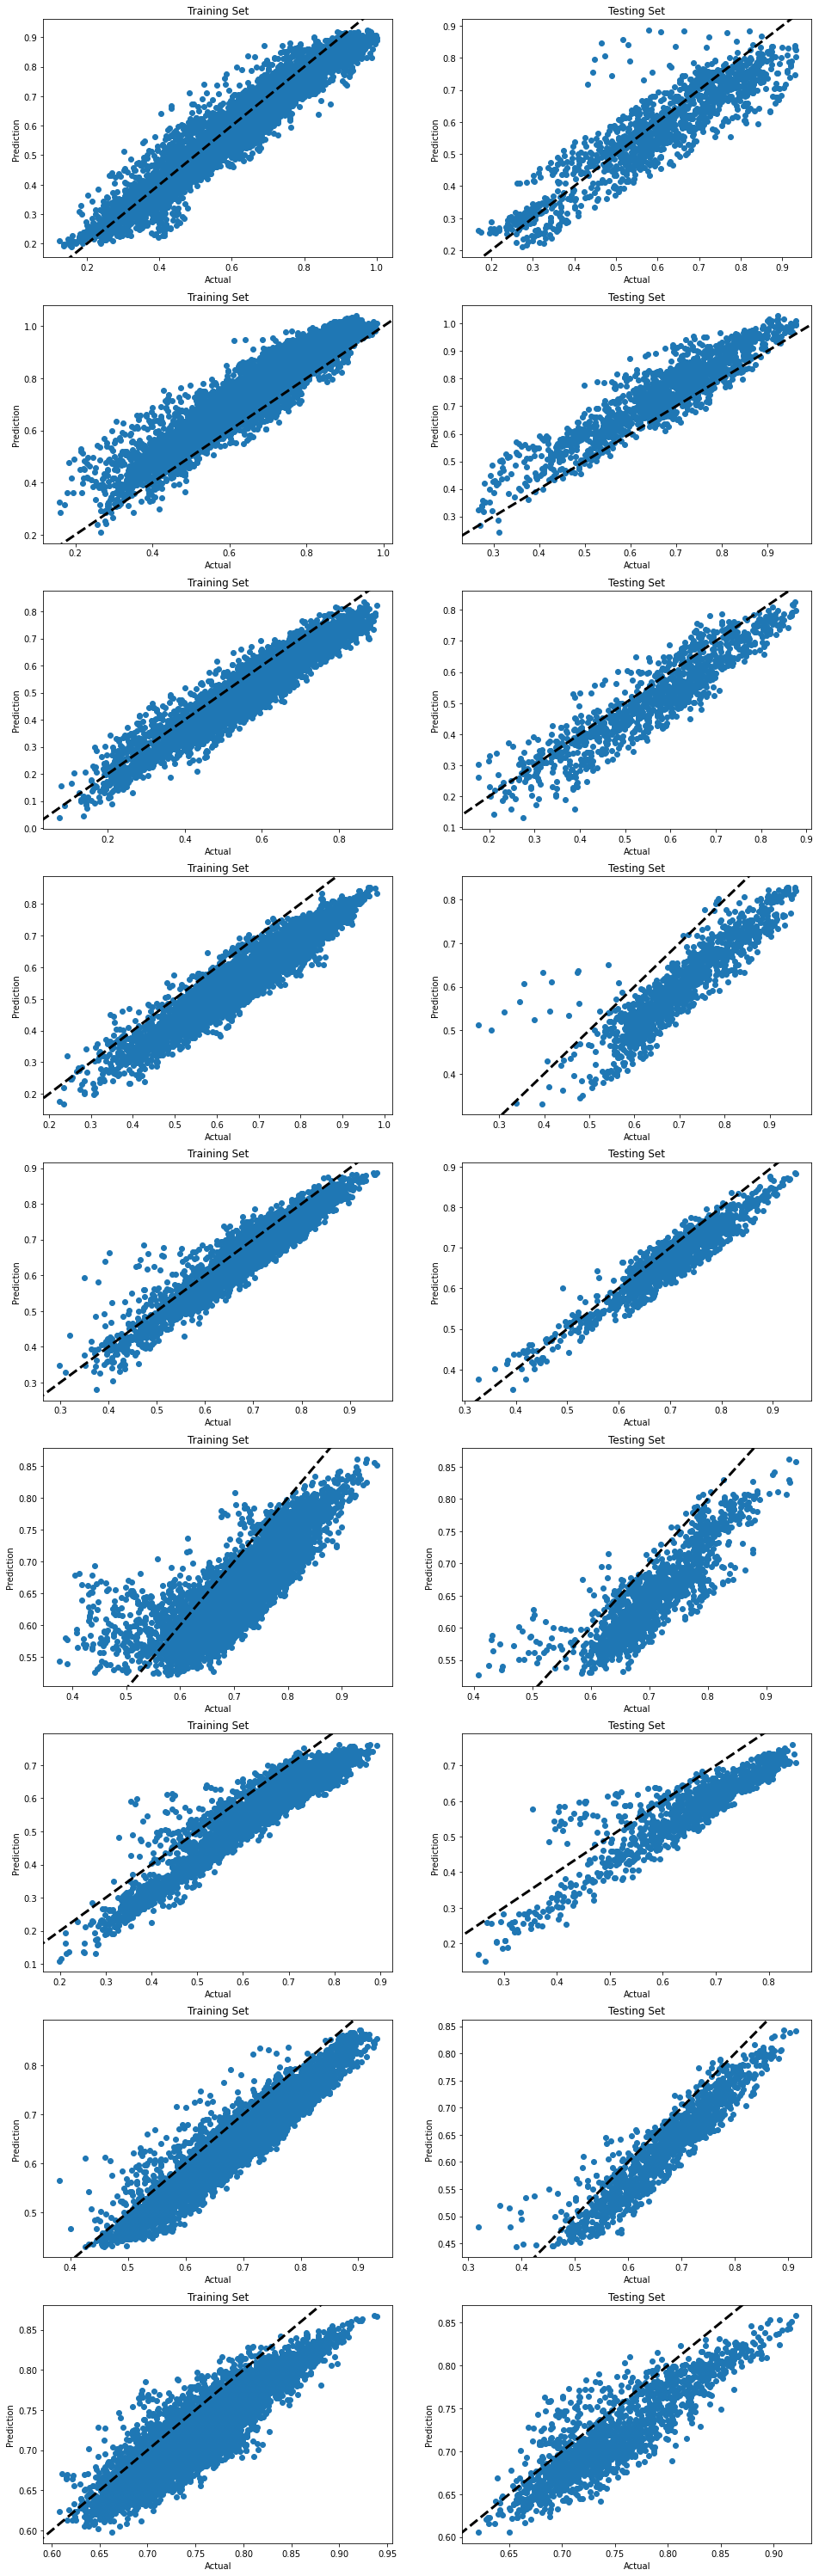

In [ ]:
plt.rcParams["figure.figsize"] = (16,54)
fig, ax = plt.subplots(len(selected_grids_daily), 2)
for i in range(len(selected_grids_daily)):
    ax[i,0].scatter(pred_train[i][0][:,:,:,0].reshape(pred_train[i][0][:,:,:,0].shape[0], -1), 
                    pred_train[i][1][:,:,:,0].reshape(pred_train[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # min of both axes
        np.max([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # max of both axes
    ]
    ax[i,0].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,0].set_title("Training Set")
    ax[i,0].set_xlabel("Actual")
    ax[i,0].set_ylabel("Prediction")
    ax[i,1].scatter(pred_test[i][0][:,:,:,0].reshape(pred_test[i][0][:,:,:,0].shape[0], -1), 
                    pred_test[i][1][:,:,:,0].reshape(pred_test[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # min of both axes
        np.max([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # max of both axes
    ]
    ax[i,1].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,1].set_title("Testing Set")
    ax[i,1].set_xlabel("Actual")
    ax[i,1].set_ylabel("Prediction")

In [ ]:
## Daily model no fire features
max_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = False, mode = "daily", aggregation_type = "max", 
                                                                        learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 2.8960641022858793
MAPE: 0.00959095914715739
R2_score: 0.611477056011483


MAE: 4.904188890474758
MAPE: 0.016184057688841607
R2_score: -0.36078170296194684


MAE: 2.0537572382146667
MAPE: 0.006862928927010757
R2_score: 0.7114382374932913


MAE: 1.911683843485516
MAPE: 0.0062444724886802526
R2_score: 0.5978559407561037


MAE: 1.8602525630950941
MAPE: 0.006119125322153386
R2_score: 0.34537976190524416


MAE: 1.8765673962008567
MAPE: 0.006125929373476586
R2_score: 0.34515377939449676


MAE: 1.6301682655071397
MAPE: 0.005410065177299364
R2_score: 0.46689609248003255


MAE: 3.067475090954349
MAPE: 0.010069366312128632
R2_score: -0.4626881428948383


MAE: 1.2647592693328877
MAPE: 0.004116673882987832
R2_score: 0.521417153583407




In [ ]:
## Daily model with existence of fire features
max_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = True, mode = "daily", aggregation_type = "max", 
                                                                        learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_max['temperature_max'][1] - min_era5_land_max['temperature_min'][1]) + \
                                min_era5_land_max['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 3.352309419307003
MAPE: 0.011015091998020761
R2_score: 0.48628098558517807


MAE: 3.066649344951922
MAPE: 0.010154124574567151
R2_score: 0.3527311654921435


MAE: 2.118007088401102
MAPE: 0.007042018489389166
R2_score: 0.6931862554865391


MAE: 1.8357482813517274
MAPE: 0.005997125672623727
R2_score: 0.6387865780124665


MAE: 2.7370520664215094
MAPE: 0.00893858949097257
R2_score: -0.11868273402636424


MAE: 1.1372157234437992
MAPE: 0.00372731703345349
R2_score: 0.7025335948535377


MAE: 2.295011435462689
MAPE: 0.007551198120301281
R2_score: 0.28304224247925985


MAE: 2.242057220818013
MAPE: 0.007357308558304133
R2_score: 0.17598669126378963


MAE: 0.8415326786041263
MAPE: 0.002743458421746426
R2_score: 0.7328162738663191




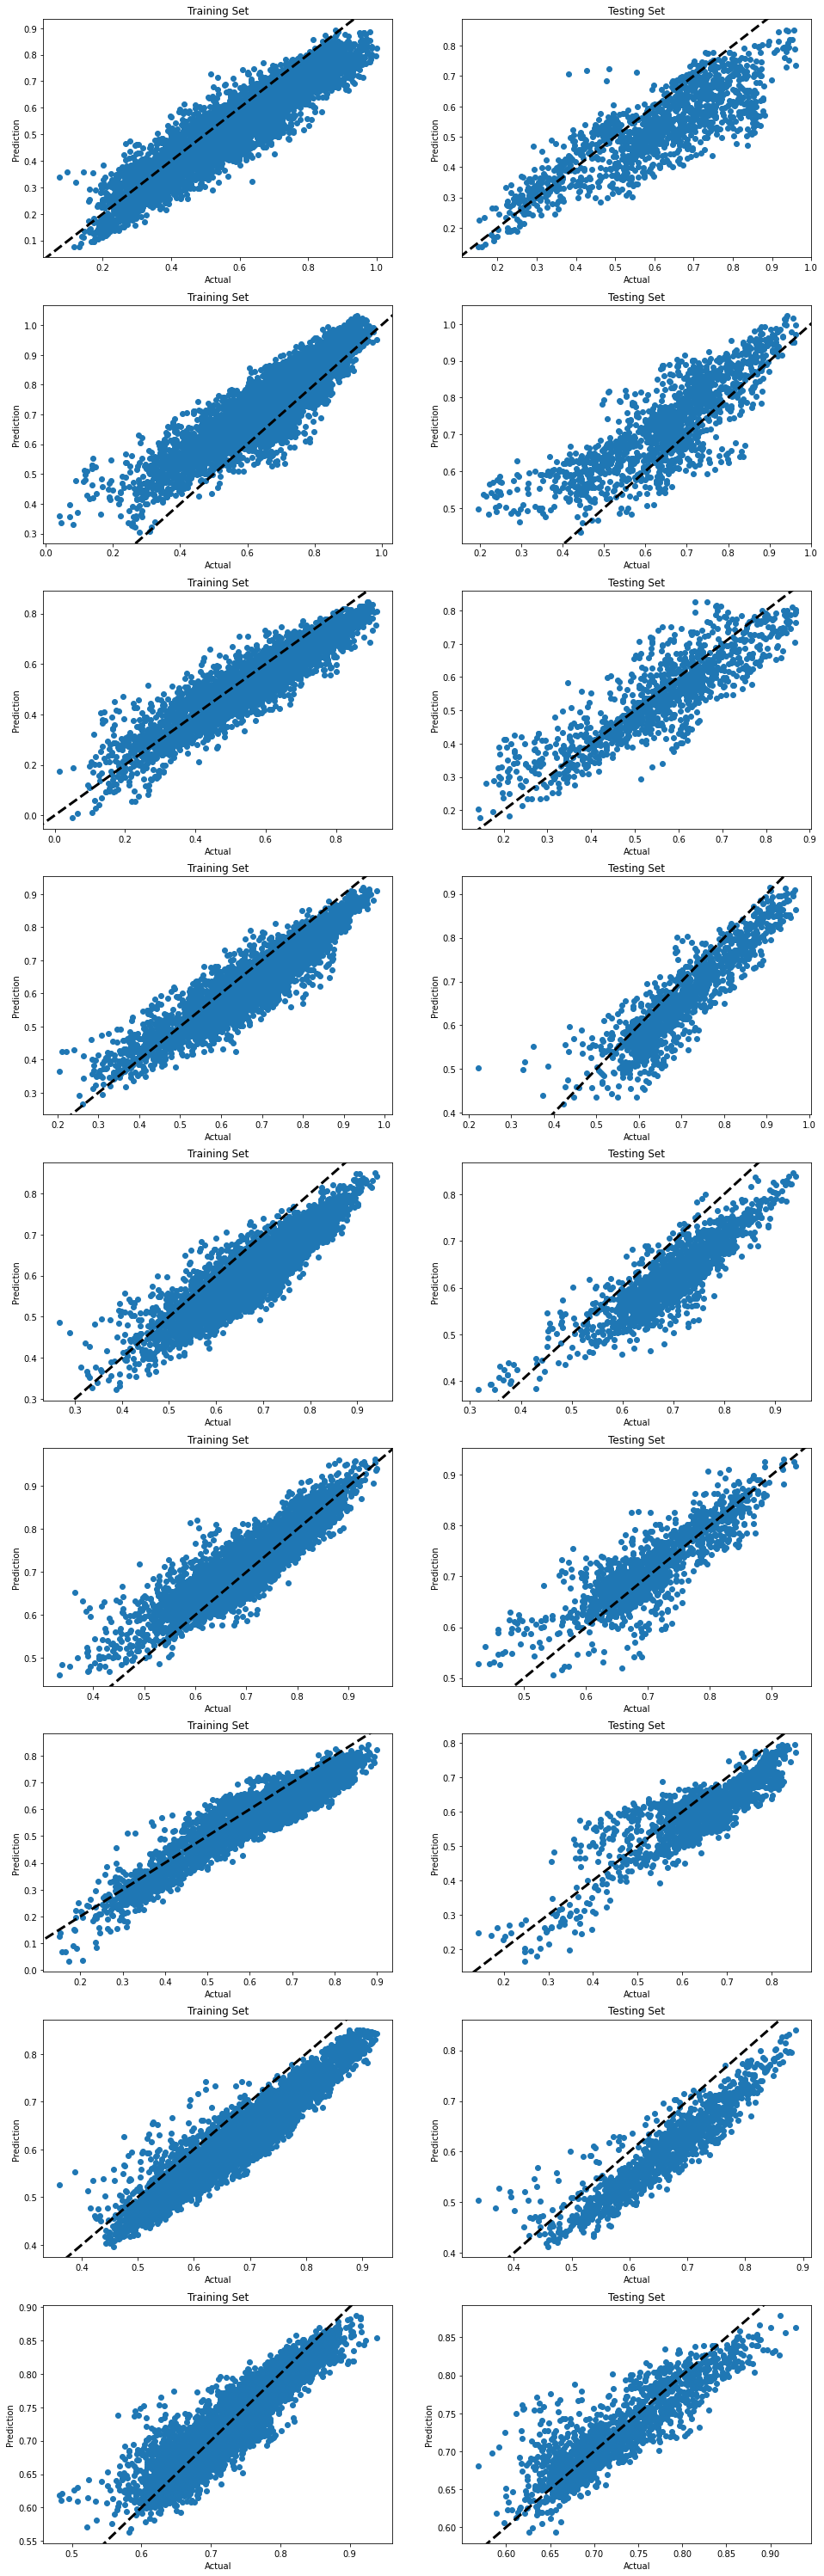

In [ ]:
plt.rcParams["figure.figsize"] = (16,54)
fig, ax = plt.subplots(len(selected_grids_daily), 2)
for i in range(len(selected_grids_daily)):
    ax[i,0].scatter(pred_train[i][0][:,:,:,0].reshape(pred_train[i][0][:,:,:,0].shape[0], -1), 
                    pred_train[i][1][:,:,:,0].reshape(pred_train[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # min of both axes
        np.max([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # max of both axes
    ]
    ax[i,0].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,0].set_title("Training Set")
    ax[i,0].set_xlabel("Actual")
    ax[i,0].set_ylabel("Prediction")
    ax[i,1].scatter(pred_test[i][0][:,:,:,0].reshape(pred_test[i][0][:,:,:,0].shape[0], -1), 
                    pred_test[i][1][:,:,:,0].reshape(pred_test[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # min of both axes
        np.max([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # max of both axes
    ]
    ax[i,1].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,1].set_title("Testing Set")
    ax[i,1].set_xlabel("Actual")
    ax[i,1].set_ylabel("Prediction")

In [ ]:
## Daily model no fire features
min_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = False, mode = "daily", aggregation_type = "min", 
                                                                        learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 2.049817194281684
MAPE: 0.00705132343440767
R2_score: 0.7687418313394265


MAE: 3.142571263521634
MAPE: 0.010731447445446893
R2_score: 0.24476633417302898


MAE: 2.2446809020996135
MAPE: 0.007724443877263914
R2_score: 0.6439416914049616


MAE: 1.9615389643351233
MAPE: 0.006664149077087347
R2_score: 0.5271299713410204


MAE: 3.4070480869293203
MAPE: 0.01154948564698165
R2_score: -0.7686088402072939


MAE: 1.46581927411479
MAPE: 0.00499031540137012
R2_score: 0.42896702871161063


MAE: 1.1795565627525597
MAPE: 0.004024652353513217
R2_score: 0.719703149569625


MAE: 4.4060899696499725
MAPE: 0.015025806320005008
R2_score: -2.0363988193384497


MAE: 1.1307715297698968
MAPE: 0.0038263019463769003
R2_score: 0.2147806039346436




In [ ]:
## Daily model with existence of fire features
min_temp_daily_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = True, mode = "daily", aggregation_type = "min", 
                                                                        learning_rate = 0.0001, epochs = 100, batch = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1], 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (max_era5_land_min['temperature_max'][1] - min_era5_land_min['temperature_min'][1]) + \
                                min_era5_land_min['temperature_min'][1]
                        )
    ))
    print("\n")

MAE: 2.4229048145435472
MAPE: 0.008357986445075412
R2_score: 0.6996935697744681


MAE: 1.9921129334435101
MAPE: 0.006811178141033855
R2_score: 0.6399764926742368


MAE: 1.9395031788219146
MAPE: 0.006694238924255274
R2_score: 0.7177823517110429


MAE: 1.5315860387166333
MAPE: 0.0052128684137608405
R2_score: 0.6714560693056489


MAE: 0.920983188247681
MAPE: 0.003136559623640725
R2_score: 0.8159271550407038


MAE: 2.8726253933814236
MAPE: 0.009767116399013183
R2_score: -0.8085773622410598


MAE: 0.8369380897258892
MAPE: 0.0028639375357448673
R2_score: 0.8082729073613268


MAE: 1.188566524490657
MAPE: 0.004060681399459997
R2_score: 0.6768480373594176


MAE: 0.8029615833282512
MAPE: 0.002710551558718335
R2_score: 0.573855649619264




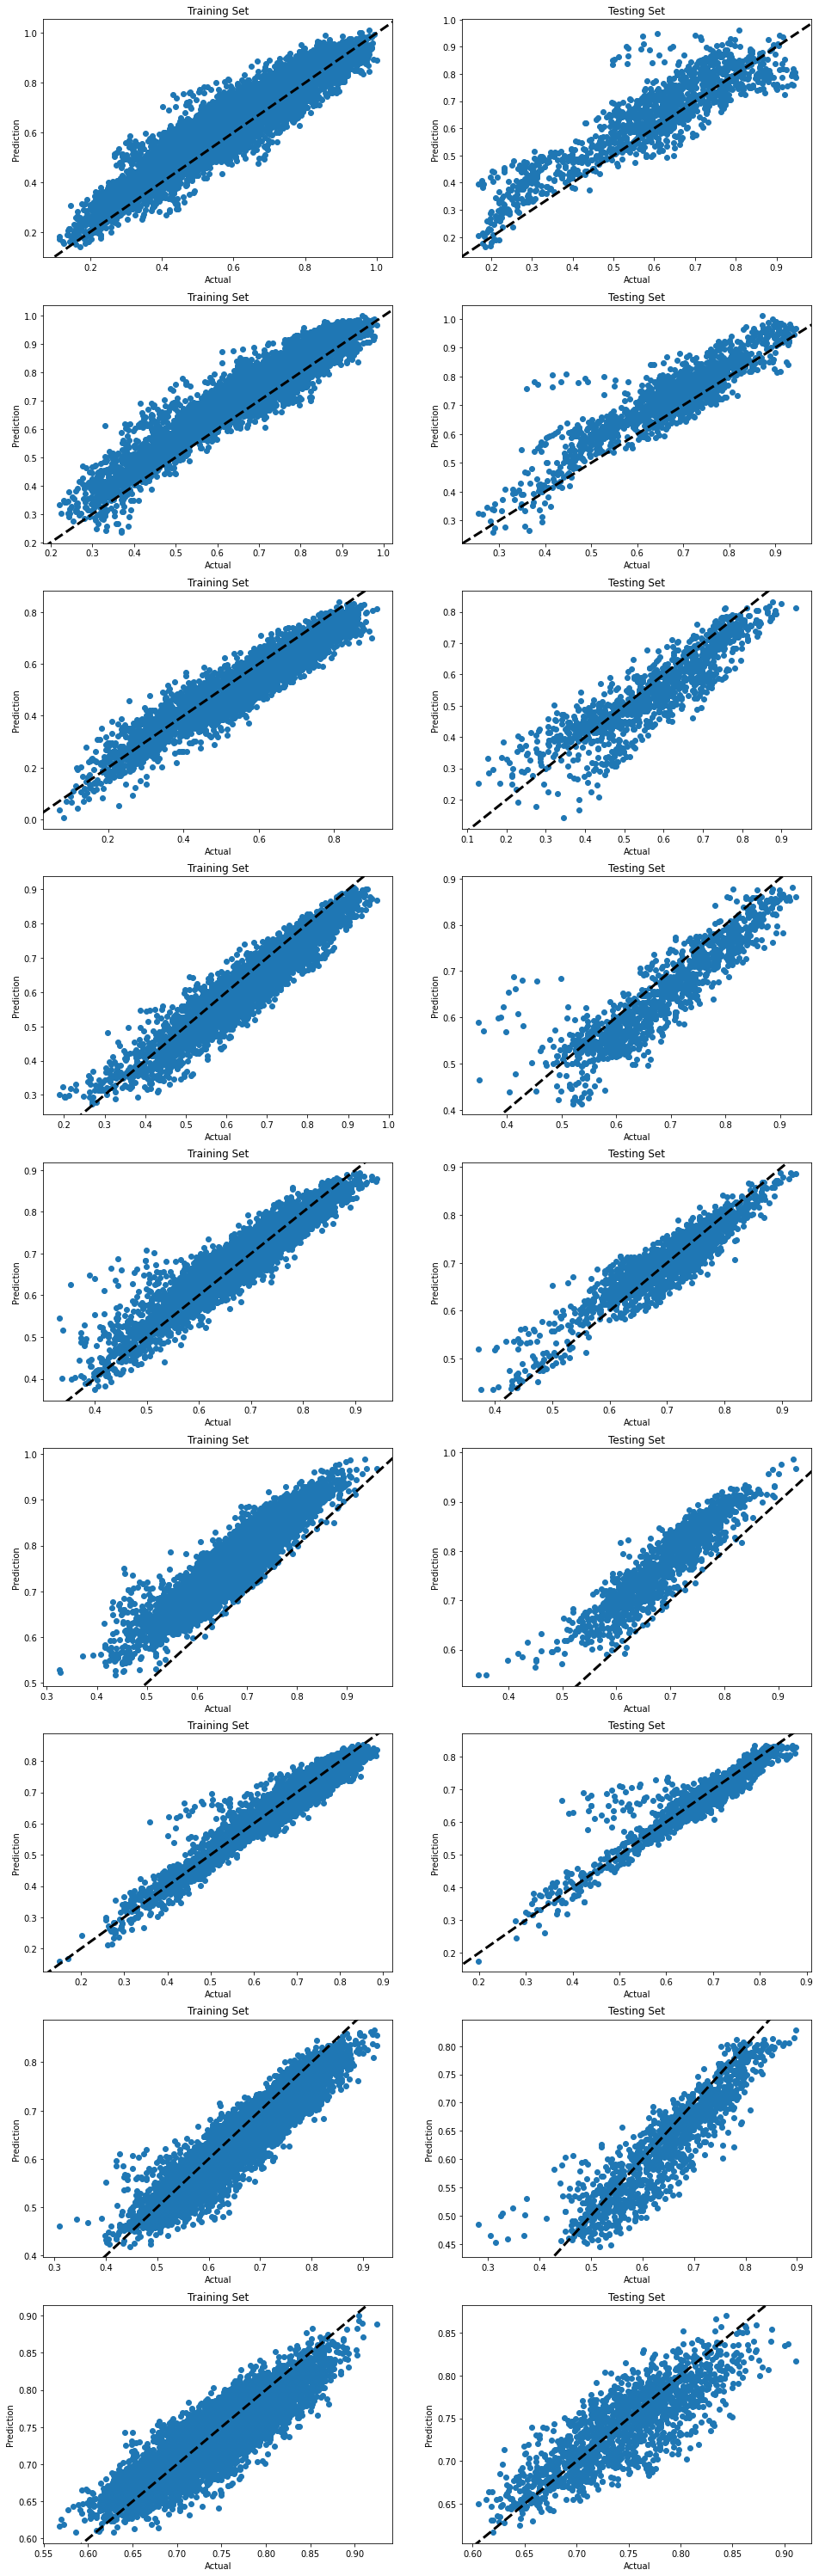

In [ ]:
plt.rcParams["figure.figsize"] = (16,54)
fig, ax = plt.subplots(len(selected_grids_daily), 2)
for i in range(len(selected_grids_daily)):
    ax[i,0].scatter(pred_train[i][0][:,:,:,0].reshape(pred_train[i][0][:,:,:,0].shape[0], -1), 
                    pred_train[i][1][:,:,:,0].reshape(pred_train[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # min of both axes
        np.max([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # max of both axes
    ]
    ax[i,0].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,0].set_title("Training Set")
    ax[i,0].set_xlabel("Actual")
    ax[i,0].set_ylabel("Prediction")
    ax[i,1].scatter(pred_test[i][0][:,:,:,0].reshape(pred_test[i][0][:,:,:,0].shape[0], -1), 
                    pred_test[i][1][:,:,:,0].reshape(pred_test[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # min of both axes
        np.max([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # max of both axes
    ]
    ax[i,1].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,1].set_title("Testing Set")
    ax[i,1].set_xlabel("Actual")
    ax[i,1].set_ylabel("Prediction")

In [ ]:
## Monthly model no fire features
temp_monthly_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = False, mode = "monthly", aggregation_type = None,
                                                                      learning_rate = 0.0001, epochs = 60, batch = 4)

In [ ]:
print("MAE: " + str(mean_absolute_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1], 
                                        np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1])))
print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1], 
                                                    np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1])))
print("R-squared: " + str(r2_score(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1], 
                                   np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1])))

MAE: 0.7129145
MAPE: 0.0023954026
R-squared: 0.8764873921421007


In [ ]:
for n in range(len(selected_grids_monthly))):
    print("MAE: " + str(mean_absolute_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1], 
                                            np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1]))
          )
    print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1], 
                                                        np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1]))
          )
    print("R-squared: " + str(r2_score(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1], 
                                       np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1]))
          )
    print("\n")

MAE: 1.0805112
MAPE: 0.0036590295
R-squared: 0.8655562711408326


MAE: 0.6604615
MAPE: 0.0022312761
R-squared: 0.7366717295041298


MAE: 0.5572992
MAPE: 0.0018568077
R-squared: 0.7925977667834209


MAE: 0.7302405
MAPE: 0.002441884
R-squared: 0.6688721135645239


MAE: 0.52317595
MAPE: 0.0017419143
R-squared: 0.8256213172194935




In [ ]:
print("MAE: " + str(mean_absolute_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1], 
                                        np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1])))
print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1], 
                                                    np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1])))
print("R-squared: " + str(r2_score(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1], 
                                   np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1])))

MAE: 0.7608775
MAPE: 0.00255324
R-squared: 0.8324394077644601


In [ ]:
for n in range(len(selected_grids_monthly))):
    print("MAE: " + str(mean_absolute_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1], 
                                            np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1]))
          )
    print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1], 
                                                        np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1]))
          )
    print("R-squared: " + str(r2_score(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1], 
                                       np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1]))
          )
    print("\n")

MAE: 1.2078652
MAPE: 0.004082369
R-squared: 0.7999430717966762


MAE: 0.6587831
MAPE: 0.0022176094
R-squared: 0.5818930648495219


MAE: 0.61295784
MAPE: 0.002041491
R-squared: 0.6181003921723743


MAE: 0.7864003
MAPE: 0.002631261
R-squared: 0.5189951154348333


MAE: 0.5369337
MAPE: 0.001788335
R-squared: 0.7716890618359499




In [ ]:
## Monthly model with existence of fire features
temp_monthly_model, pred_train, pred_test = train_predict_temperature(is_wildfire_features = True, mode = "monthly", aggregation_type = None,
                                                                      learning_rate = 0.0001, epochs = 80, batch = 4)

In [ ]:
print("MAE: " + str(mean_absolute_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1], 
                                        np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1])))
print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1], 
                                                    np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1])))
print("R-squared: " + str(r2_score(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1], 
                                   np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1])))

MAE: 0.5877237
MAPE: 0.0019737787
R-squared: 0.9200723191089646


In [ ]:
for n in range(len(selected_grids_monthly))):
    print("MAE: " + str(mean_absolute_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1], 
                                            np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1]))
          )
    print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1], 
                                                        np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1]))
          )
    print("R-squared: " + str(r2_score(np.power(pred_train[i][0].reshape(pred_train[i][0].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1], 
                                       np.power(pred_train[i][1].reshape(pred_train[i][1].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1]))
          )
    print("\n")

MAE: 0.8162208
MAPE: 0.002761501
R-squared: 0.9267948806643648


MAE: 0.53802097
MAPE: 0.0018188297
R-squared: 0.8248713702012399


MAE: 0.4976243
MAPE: 0.0016584591
R-squared: 0.834271047541379


MAE: 0.5816958
MAPE: 0.0019456539
R-squared: 0.7808716955207766


MAE: 0.49383476
MAPE: 0.0016445298
R-squared: 0.8454319962382828




In [ ]:
print("MAE: " + str(mean_absolute_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1], 
                                        np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                        min_era5_land_monthly['temperature_min'][1])))
print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1], 
                                                    np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                                    (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                    min_era5_land_monthly['temperature_min'][1])))
print("R-squared: " + str(r2_score(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1], 
                                   np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                   (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                   min_era5_land_monthly['temperature_min'][1])))

MAE: 0.7026335
MAPE: 0.0023572182
R-squared: 0.867978979246161


In [ ]:
for n in range(len(selected_grids_monthly))):
    print("MAE: " + str(mean_absolute_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1], 
                                            np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                            (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                            min_era5_land_monthly['temperature_min'][1]))
          )
    print("MAPE: " + str(mean_absolute_percentage_error(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1], 
                                                        np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                                        (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                                        min_era5_land_monthly['temperature_min'][1]))
          )
    print("R-squared: " + str(r2_score(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1], 
                                       np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                                       (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                                       min_era5_land_monthly['temperature_min'][1]))
          )
    print("\n")

MAE: 1.0011439
MAPE: 0.003382675
R-squared: 0.8730658902340321


MAE: 0.63541204
MAPE: 0.0021390442
R-squared: 0.6418628731518312


MAE: 0.5409086
MAPE: 0.0018022091
R-squared: 0.6787639661983927


MAE: 0.76968193
MAPE: 0.0025763626
R-squared: 0.5329420552441155


MAE: 0.5660349
MAPE: 0.0018858437
R-squared: 0.749855823584933




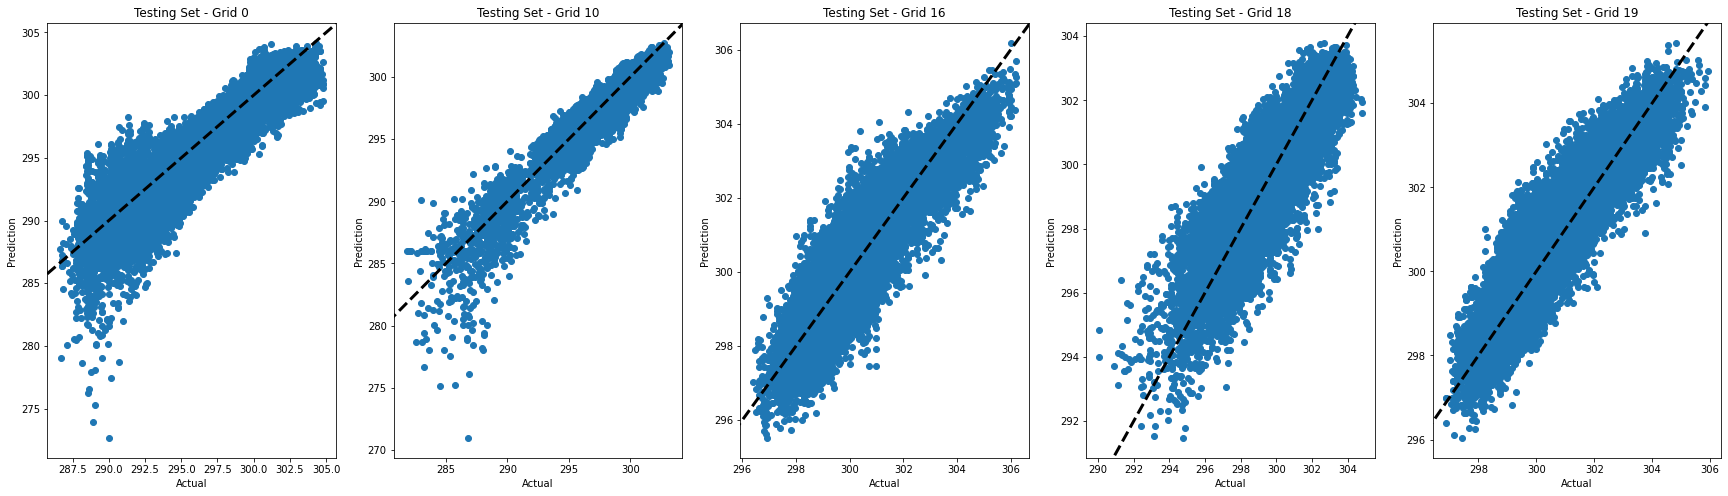

In [ ]:
plt.rcParams["figure.figsize"] = (30,8)
fig, ax = plt.subplots(1, 5)
for n in range(len(selected_grids_monthly)):
    ax[n].scatter(np.power(pred_test[i][0].reshape(pred_test[i][0].shape[0], -1), 1/3) * \
                  (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                  min_era5_land_monthly['temperature_min'][1], 
                  np.power(pred_test[i][1].reshape(pred_test[i][1].shape[0], -1), 1/3) * \
                  (max_era5_land_monthly['temperature_max'][1] - min_era5_land_monthly['temperature_min'][1]) + \
                  min_era5_land_monthly['temperature_min'][1],
    marker='o')
    lims = [
        np.min([ax[n].get_xlim(), ax[n].get_ylim()]),  # min of both axes
        np.max([ax[n].get_xlim(), ax[n].get_ylim()]),  # max of both axes
    ]
    ax[n].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[n].set_title("Testing Set - " + "Grid " + str(selected_grids[n]))
    ax[n].set_xlabel("Actual")
    ax[n].set_ylabel("Prediction")

#### 5.3) Deep Learning Models (Precipitation Event Prediction & Sum of Precipitation Forecast)

Due to the the fact that values of the ERA5-LAND data were reconstructed or forecasted by climatic models, there could be some insignificantly small outputted values for some variables like precipitation as computed from the estimates, and practically these values had no meanings since rainfall less than 0.01 mm within a day could be somehow neglectable. The weather foreast nowadays usually presented precipitation predictions as a probability indicating how likely it will rain in the following days. Therefore, in the following constructed model classes, a two-step appproach was adopted, and the targets comprised of a binarized pixelwise precipitation event attribute and a ontinuous target of the sum of amounts of rainfalls. 

For daily prediction on the precipitation event, the improvements contributed by adding the wildfire features were small, except for grid 2 and grid 10. Grid 2 had a relatively small percentage of wildfire occurrences while Grid 10 was among the most frequently wildfire-impacted locations, hence the variations might be dependent on local topological and landscape factors, or their interactions and dynamics under wildfire spreads. Unlike the wildfire occurrences in which we focused on the performance of positive pixels, the weighted average of both classes might be better indicator for the precipitaion events as both sides could bring undesirable impacts (flooding and droughts). In terms of the regression on the amounts of precipitations, 5 or 6 grids out of 9 grids had a small extent of improvements on the error rates. For monthly aggregated precipitations, the MAEs achieved was better than the MAEs in daily predictions, while the MAPEs were worse. Adding wildfire features almost had no impact on the error rates, an alternative approach might be needed for the investigations and benchmark of the long-term wildfire-induced effects on meteorological data.

Daily Predictions (Precision, Recall and F1-score weighted average based on the binary class - precipitation occurrences > 1 mm or not)

** N.I. = No Improvement

<table>
  <thead>
  <tr>
      <th></th>
      <th></th>
      <th colspan="8">With no wildfire image features</th>
      <th colspan="8">With existence of wildfire image features</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th colspan="4">Training Set</th>
      <th colspan="4">Testing Set</th>
      <th colspan="4">Training Set</th>
      <th colspan="4">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires</th>
      <th>precision</th>	
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
      <th>precision</th>
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
      <th>precision</th>	
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
      <th>precision</th>
      <th>recall</th>
      <th>f1-score</th>
      <th>accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>26.57%</td>
      <td>0.92</td>
      <td>0.92</td>
      <td>0.92</td>
      <td>0.92</td>
      <td>0.79</td>
      <td>0.81</td>
      <td>0.80</td>
      <td>0.81</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.89</td>
      <td>0.90</td>
      <td>0.81</td>
      <td>0.83</td>
      <td>0.81</td>
      <td>0.83</td>
    </tr>
    <tr>
      <td>1</td>
      <td>22.45%</td>
      <td>0.89</td>
      <td>0.88</td>
      <td>0.87</td>
      <td>0.88</td>
      <td>0.83</td>
      <td>0.85</td>
      <td>0.81</td>
      <td>0.82</td>
      <td>0.89</td>
      <td>0.88</td>
      <td>0.86</td>
      <td>0.88</td>
      <td>0.82</td>
      <td>0.84</td>
      <td>0.79</td>
      <td>0.84</td>
    </tr>
    <tr>
      <td>2</td>
      <td>12.82%</td>
      <td>0.89</td>
      <td>0.69</td>
      <td>0.74</td>
      <td>0.69</td>
      <td>0.80</td>
      <td>0.56</td>
      <td>0.59</td>
      <td>0.56</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.80</td>
      <td>0.80</td>
      <td>0.80</td>
      <td>0.80</td>
    </tr>
    <tr>
      <td>3</td>
      <td>11.79%</td>
      <td>0.95</td>
      <td>0.93</td>
      <td>0.94</td>
      <td>0.93</td>
      <td>0.91</td>
      <td>0.89</td>
      <td>0.90</td>
      <td>0.89</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>4</td>
      <td>19.90%</td>
      <td>0.92</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.91</td>
      <td>0.89</td>
      <td>0.90</td>
      <td>0.89</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>6</td>
      <td>17.53%</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>10</td>
      <td>24.98%</td>
      <td>0.84</td>
      <td>0.69</td>
      <td>0.70</td>
      <td>0.69</td>
      <td>0.84</td>
      <td>0.66</td>
      <td>0.68</td>
      <td>0.66</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.82</td>
      <td>0.80</td>
      <td>0.81</td>
      <td>0.80</td>
    </tr>
    <tr>
      <td>13</td>
      <td>16.22%</td>
      <td>0.93</td>
      <td>0.85</td>
      <td>0.87</td>
      <td>0.85</td>
      <td>0.94</td>
      <td>0.82</td>
      <td>0.85</td>
      <td>0.82</td>
      <td>0.94</td>
      <td>0.92</td>
      <td>0.93</td>
      <td>0.92</td>
      <td>0.93</td>
      <td>0.90</td>
      <td>0.91</td>
      <td>0.90</td>
    </tr>
    <tr>
      <td>16</td>
      <td>25.89%</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.95</td>
      <td>0.90</td>
      <td>0.90</td>
      <td>0.89</td>
      <td>0.90</td>
      <td>0.96</td>
      <td>0.96</td>
      <td>0.96</td>
      <td>0.96</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>0.93</td>
    </tr>
  </tbody>
</table>

Daily Predictions

** N.I. = No Improvement


<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="6">With no wildfire image features</th>
      <th colspan="6">With existence of wildfire image features</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>26.57%</td>
      <td>2.07</td>
      <td>3.04%</td>
      <td>0.60</td>
      <td>2.39</td>
      <td>3.49%</td>
      <td>0.41</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>1</td>
      <td>22.45%</td>
      <td>1.77</td>
      <td>3.25%</td>
      <td>0.67</td>
      <td>2.46</td>
      <td>12.98%</td>
      <td>0.29</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>2</td>
      <td>12.82%</td>
      <td>2.40</td>
      <td>3.32%</td>
      <td>0.40</td>
      <td>2.88</td>
      <td>2.72%</td>
      <td>0.16</td>
      <td>1.96</td>
      <td>3.03%</td>
      <td>0.58</td>
      <td>2.68</td>
      <td>2.90%</td>
      <td>0.31</td>
    </tr>
    <tr>
      <td>3</td>
      <td>11.79%</td>
      <td>1.73</td>
      <td>2.76%</td>
      <td>0.65</td>
      <td>2.35</td>
      <td>1.83%</td>
      <td>0.43</td>
      <td>1.57</td>
      <td>2.60%</td>
      <td>0.72</td>
      <td>2.32</td>
      <td>2.59%</td>
      <td>0.49</td>
    </tr>
    <tr>
      <td>4</td>
      <td>19.90%</td>
      <td>1.38</td>
      <td>1.82%</td>
      <td>0.81</td>
      <td>1.76</td>
      <td>2.07%</td>
      <td>0.60</td>
      <td>1.39</td>
      <td>1.57%</td>
      <td>0.81</td>
      <td>1.45</td>
      <td>1.60%</td>
      <td>0.67</td>
    </tr>
    <tr>
      <td>6</td>
      <td>17.53%</td>
      <td>1.89</td>
      <td>3.07%</td>
      <td>0.71</td>
      <td>1.84</td>
      <td>2.95%</td>
      <td>0.70</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
      <td>N.I.</td>
    </tr>
    <tr>
      <td>10</td>
      <td>24.98%</td>
      <td>1.46</td>
      <td>3.63%</td>
      <td>0.66</td>
      <td>1.74</td>
      <td>1.81%</td>
      <td>0.58</td>
      <td>1.31</td>
      <td>3.00%</td>
      <td>0.73</td>
      <td>1.58</td>
      <td>1.72%</td>
      <td>0.64</td>
    </tr>
    <tr>
      <td>13</td>
      <td>16.22%</td>
      <td>1.43</td>
      <td>3.22%</td>
      <td>0.76</td>
      <td>1.42</td>
      <td>1.01%</td>
      <td>0.61</td>
      <td>1.34</td>
      <td>2.63%</td>
      <td>0.78</td>
      <td>1.33</td>
      <td>0.94%</td>
      <td>0.64</td>
    </tr>
    <tr>
      <td>16</td>
      <td>25.89%</td>
      <td>1.84</td>
      <td>2.01%</td>
      <td>0.70</td>
      <td>2.13</td>
      <td>2.18%</td>
      <td>0.57</td>
      <td>1.12</td>
      <td>1.16%</td>
      <td>0.86</td>
      <td>1.56</td>
      <td>1.43%</td>
      <td>0.68</td>
    </tr>
  </tbody>
</table>

Monthly Predictions  (Total precipitations in the month)

<table>
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="6">With no wildfire image features</th>
      <th colspan="6">With existence of wildfire image features</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
      <th colspan="3">Training Set</th>
      <th colspan="3">Testing Set</th>
    </tr>
    <tr>
      <th>Grid</th>
      <th>Percentage of Fires</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
      <th>MAE</th>	
      <th>MAPE</th>
      <th>R-squared</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>11.43%</td>
      <td>0.47</td>
      <td>4.01%</td>
      <td>0.50</td>
      <td>0.47</td>
      <td>4.05%</td>
      <td>0.44</td>
      <td>0.48</td>
      <td>4.01%</td>
      <td>0.50</td>
      <td>0.48</td>
      <td>4.08%</td>
      <td>0.43</td>
    </tr>
    <tr>
      <td>10</td>
      <td>10.45%</td>
      <td>0.39</td>
      <td>3.27%</td>
      <td>0.79</td>
      <td>0.45</td>
      <td>3.89%</td>
      <td>0.70</td>
      <td>0.36</td>
      <td>3.06%</td>
      <td>0.80</td>
      <td>0.40</td>
      <td>3.50%</td>
      <td>0.75</td>
    </tr>
    <tr>
      <td>16</td>
      <td>14.29%</td>
      <td>0.46</td>
      <td>4.32%</td>
      <td>0.95</td>
      <td>0.62</td>
      <td>5.90%</td>
      <td>0.88</td>
      <td>0.51</td>
      <td>4.89%</td>
      <td>0.94</td>
      <td>0.60</td>
      <td>5.79%</td>
      <td>0.89</td>
    </tr>
    <tr>
      <td>18</td>
      <td>11.80%</td>
      <td>0.58</td>
      <td>5.76%</td>
      <td>0.90</td>
      <td>0.72</td>
      <td>6.94%</td>
      <td>0.80</td>
      <td>0.57</td>
      <td>5.69%</td>
      <td>0.90</td>
      <td>0.71</td>
      <td>6.91%</td>
      <td>0.81</td>
    </tr>
    <tr>
      <td>19</td>
      <td>13.69%</td>
      <td>0.45</td>
      <td>4.19%</td>
      <td>0.90</td>
      <td>0.51</td>
      <td>4.73%</td>
      <td>0.87</td>
      <td>0.48</td>
      <td>4.42%</td>
      <td>0.90</td>
      <td>0.55</td>
      <td>5.03%</td>
      <td>0.86</td>
    </tr>
  </tbody>
</table>

In [ ]:
##  Predictive Task 3):  precipitation forecast
##  3.1) binarized precipitation event classification (i.e. less than 1 mm grouped as "no rain" class)
##  3.2) total amounts of precipitation

## i)  only ERA5 weather features without wildfire / vegetation index features
## ii) ERA5 weather features with wildfire / vegetation index features

def train_predict_precipitation(is_wildfire_features, mode, logit,
                                learning_rate, epochs, batch):

    ## self-defined parameters depending on the depth of features
    if logit == True:
        if is_wildfire_features == True:
            depth = 114
            n_encoder = 5
            n_decoder = 4
        else:
            depth = 50
            n_encoder = 2
            n_decoder = 4
    else:
        if is_wildfire_features == True:
            depth = 114
            n_encoder = 3
            n_decoder = 4
        else:
            depth = 50
            n_encoder = 1
            n_decoder = 4

    if mode == "daily":

        if logit == True:
            ## deploy or call the model class
            model_instance = BiConvLSTM_Attention_Model(
                                mode="daily", img_height=560, img_width=560, 
                                output_img_height=7, output_img_width=7, 
                                lag_window=8, neighbour_window=5,
                                land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                weather_window_height=50, weather_window_width=40
                                )
            
            ## load daily "precipitation" target array file from folder path at this point
            data_y = prec_sum_binary_daily
        else:
            ## deploy or call the model class
            model_instance = BiConvLSTM_Attention_Model(
                                mode="daily", img_height=560, img_width=560, 
                                lag_window=8, neighbour_window=5,
                                land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                weather_window_height=50, weather_window_width=40
                                )
            
            ## load daily "precipitation" target array file from folder path at this point
            data_y = prec_sum_scaled_daily

        prec_daily = []
        for grid in range(len(selected_grids_daily)):
            grid_prec_daily = model_instance
            prec_daily.append(grid_prec_daily)
        
        prec_daily_model = []
        pred_train = []
        pred_test = []

        for grid in range(len(selected_grids_daily)):
            
            data_y = data_y[grid]
            train_y = data_y[train_index[grid]]
            val_y = data_y[val_index[grid]]
            test_y = data_y[test_index[grid]]

            model = prec_daily[grid].get_model(num_encoder_layers = n_encoder, num_decoder_layers = n_decoder)
            if logit == True:
                model.compile(loss = "binary_crossentropy", 
                              optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                              metrics = ['Accuracy','TruePositives','Precision'])
            else:
                model.compile(loss = "mse", 
                              optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
                              metrics = ['MeanAbsoluteError','MeanAbsolutePercentageError','RootMeanSquaredError'])
            model.fit(train_x, train_y, epochs = epochs, batch_size = batch,
                      validation_data = (val_x, val_y),
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)])
            prec_daily_model.append(model)

            pred_train.append([train_y, prec_daily_model[grid].predict(train_x, batch_size = batch)])
            pred_test.append([test_y, prec_daily_model[grid].predict(test_x, batch_size = batch)])

        outputted_model = prec_daily_model

    elif mode == "monthly":

        if logit == True:
            ## deploy or call the model class
            prec_monthly = BiConvLSTM_Attention_Model(
                                    mode="monthly", img_height=1120, img_width=1120, 
                                    output_img_height=56, output_img_width=56, 
                                    lag_window=6, neighbour_window=5,
                                    land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                    weather_window_height=50, weather_window_width=40
                                    )
            ## load monthly "precipitation" target array file from folder path at this point
            data_y = prec_sum_binary_monthly
        else:
            prec_monthly = BiConvLSTM_Attention_Model(
                                    mode="monthly", img_height=1120, img_width=1120, 
                                    lag_window=6, neighbour_window=5,
                                    land_grid_height=50, land_grid_width=50, land_grid_features = depth,
                                    weather_window_height=50, weather_window_width=40
                                    )
            ## load monthly "precipitation" target array file from folder path at this point
            data_y = prec_sum_scaled_monthly

        pred_train = []
        pred_test = []

        data_y = data_y[selected_grids_monthly]
        train_y = data_y[[train_index[grid] for grid in selected_grids_monthly]]
        val_y = data_y[[val_index[grid] for grid in selected_grids_monthly]]
        test_y = data_y[[test_index[grid] for grid in selected_grids_monthly]]

        prec_monthly_model = prec_monthly.get_model(num_encoder_layers = n_encoder, num_decoder_layers = n_decoder)
        if logit == True:
            prec_monthly_model.compile(loss = "binary_crossentropy", 
                          optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                          metrics = ['Accuracy','TruePositives','Precision'])
        else:
            prec_monthly_model.compile(loss = "mse", 
                          optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
                          metrics = ['MeanAbsoluteError','MeanAbsolutePercentageError','RootMeanSquaredError'])
        prec_monthly_model.fit(train_x, train_y, epochs=100, batch_size=4,
                              validation_data = (val_x, val_y),
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)])

        pred_train.append([train_y, prec_monthly_model.predict(train_x, batch_size = 4)])
        pred_test.append([test_y, prec_monthly_model.predict(test_x, batch_size = 4)])

        outputted_model = prec_monthly_model

    return outputted_model, pred_train, pred_test

In [ ]:
## Daily model no fire features
prec_daily_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = False, mode = "daily", logit = True,
                                                                      learning_rate = 0.0001, epoch = 40, batch_size = 4)

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_train[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_train[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5986
           1       0.91      0.69      0.79      1589

    accuracy                           0.92      7575
   macro avg       0.92      0.84      0.87      7575
weighted avg       0.92      0.92      0.92      7575



              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7389
           1       0.91      0.44      0.59      1761

    accuracy                           0.88      9150
   macro avg       0.90      0.71      0.76      9150
weighted avg       0.89      0.88      0.87      9150



              precision    recall  f1-score   support

           0       0.99      0.65      0.78      5175
           1       0.33      0.96      0.49       950

    accuracy                           0.69      6125
   macro avg       0.66      0.80      0.64      6125
weighted avg       0.89      0.69      0.74      6125



             

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_test[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_test[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1090
           1       0.53      0.36      0.43       260

    accuracy                           0.81      1350
   macro avg       0.69      0.64      0.66      1350
weighted avg       0.79      0.81      0.80      1350



              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1329
           1       0.71      0.26      0.38       296

    accuracy                           0.85      1625
   macro avg       0.78      0.62      0.64      1625
weighted avg       0.83      0.85      0.81      1625



              precision    recall  f1-score   support

           0       0.94      0.47      0.62       858
           1       0.32      0.89      0.47       242

    accuracy                           0.56      1100
   macro avg       0.63      0.68      0.55      1100
weighted avg       0.80      0.56      0.59      1100



             

In [ ]:
## Daily model with existence of fire features
prec_daily_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = True, mode = "daily", logit = True,
                                                                      learning_rate = 0.0001, epoch = 80, batch_size = 4)

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_train[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_train[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5986
           1       0.90      0.60      0.72      1589

    accuracy                           0.90      7575
   macro avg       0.90      0.79      0.83      7575
weighted avg       0.90      0.90      0.89      7575



              precision    recall  f1-score   support

           0       0.88      1.00      0.93      7389
           1       0.97      0.41      0.57      1761

    accuracy                           0.88      9150
   macro avg       0.92      0.70      0.75      9150
weighted avg       0.89      0.88      0.86      9150



              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5175
           1       0.82      0.85      0.84       950

    accuracy                           0.95      6125
   macro avg       0.90      0.91      0.90      6125
weighted avg       0.95      0.95      0.95      6125



             

In [ ]:
for grid in range(len(selected_grids_daily)):
    a = copy.deepcopy(pred_test[grid][0].reshape(1, -1))
    b = copy.deepcopy(pred_test[grid][1].reshape(1, -1))
    b[b >= 0.5] = 1
    b[b < 0.5] = 0
    print(classification_report([str(int(x)) for x in a.tolist()[0]], [str(int(x)) for x in b.tolist()[0]]))
    print("\n")

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1090
           1       0.59      0.34      0.43       260

    accuracy                           0.83      1350
   macro avg       0.72      0.64      0.67      1350
weighted avg       0.81      0.83      0.81      1350



              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1329
           1       0.74      0.17      0.28       296

    accuracy                           0.84      1625
   macro avg       0.79      0.58      0.59      1625
weighted avg       0.82      0.84      0.79      1625



              precision    recall  f1-score   support

           0       0.87      0.87      0.87       858
           1       0.54      0.53      0.54       242

    accuracy                           0.80      1100
   macro avg       0.71      0.70      0.71      1100
weighted avg       0.80      0.80      0.80      1100



             

In [ ]:
## Daily model no fire features
prec_daily_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = False, mode = "daily", logit = False,
                                                                      learning_rate = 0.0001, epoch = 40, batch_size = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("\n")

MAE: 2.0696374094842964
MAPE: 3.0389416917278527
R2_score: 0.5971109412598374


MAE: 1.771733365912439
MAPE: 3.2534732703136924
R2_score: 0.6720415268266398


MAE: 2.404884442135763
MAPE: 3.320309505385834
R2_score: 0.4042887091677833


MAE: 1.7305299044225884
MAPE: 2.758102985316989
R2_score: 0.6548609315498246


MAE: 1.3800306794921788
MAPE: 1.8156090871568902
R2_score: 0.8137758913244523


MAE: 1.8918970688214143
MAPE: 3.066102413326176
R2_score: 0.7122400342098877


MAE: 1.4599602611129936
MAPE: 3.634305352349682
R2_score: 0.6637679827568874


MAE: 1.4306700742445941
MAPE: 3.220869096015897
R2_score: 0.7585384237367667


MAE: 1.8434986403558262
MAPE: 2.012973157447658
R2_score: 0.7000375946897841




In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("\n")

MAE: 2.3869242988688844
MAPE: 3.48533570011043
R2_score: 0.40757215505684613


MAE: 2.460781202041775
MAPE: 12.974710781547515
R2_score: 0.29209031611559655


MAE: 2.8765962840755845
MAPE: 2.717863351117332
R2_score: 0.1594904316322627


MAE: 2.354650984528827
MAPE: 1.8285509855850188
R2_score: 0.4267984905922684


MAE: 1.7602116418493097
MAPE: 2.0749243130560457
R2_score: 0.5957203073358697


MAE: 1.8353047935172615
MAPE: 2.9536808984608403
R2_score: 0.6978423101708389


MAE: 1.7408559345718608
MAPE: 1.81099205972367
R2_score: 0.57721435973334


MAE: 1.422960396484155
MAPE: 1.0089986807649958
R2_score: 0.610767493539655


MAE: 2.128201227165148
MAPE: 2.1750136488216842
R2_score: 0.570728434103449




In [ ]:
## Daily model with existence of fire features
prec_daily_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = True, mode = "daily", logit = False,
                                                                      learning_rate = 0.0001, epoch = 80, batch_size = 4)

In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_train[i][0].reshape(pred_train[i][0].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_train[i][1].reshape(pred_train[i][1].shape[0], -1) * \
                                 (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                 np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("\n")

MAE: 2.9448010008341208
MAPE: 2.322655764990462
R2_score: 0.22749762224874906


MAE: 2.3623818615029193
MAPE: 4.871090347898946
R2_score: 0.4820725030275782


MAE: 1.9596567883345417
MAPE: 3.033349831632474
R2_score: 0.5810655922316271


MAE: 1.5666729948297882
MAPE: 2.5971776508831543
R2_score: 0.7210797379605741


MAE: 1.387721654886979
MAPE: 1.5748057204112413
R2_score: 0.8081613868849896


MAE: 1.9882145275963985
MAPE: 3.5610205441600398
R2_score: 0.664414479466309


MAE: 1.30659602368015
MAPE: 2.997190193445883
R2_score: 0.7255419528794148


MAE: 1.3387562821290693
MAPE: 2.6287073533141037
R2_score: 0.7750399623786669


MAE: 1.1184154522460863
MAPE: 1.162978591669434
R2_score: 0.8624349975112241




In [ ]:
for i in range(len(selected_grids_daily)):
    print("MAE: " + str(
    mean_absolute_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("MAPE: " + str(
    mean_absolute_percentage_error(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("R2_score: " + str(
    r2_score(
        pred_test[i][0].reshape(pred_test[i][0].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation']), 
        pred_test[i][1].reshape(pred_test[i][1].shape[0], -1) * \
                                (np.max(era5_land_daily_bands_sum['precipitation']) - np.min(era5_land_daily_bands_sum['precipitation'])) + \
                                np.min(era5_land_daily_bands_sum['precipitation'])
                        )
    ))
    print("\n")

MAE: 3.113773612806783
MAPE: 2.8132042179701484
R2_score: -0.05192076590484364


MAE: 2.927195835556704
MAPE: 18.36008888150888
R2_score: 0.06989951804721027


MAE: 2.6853693851500977
MAPE: 2.9050871163231475
R2_score: 0.3051965257348472


MAE: 2.317532635869999
MAPE: 2.5931191687845523
R2_score: 0.48594639672084533


MAE: 1.4536311026926148
MAPE: 1.6025229956161255
R2_score: 0.6726075812774113


MAE: 1.8539113849187439
MAPE: 3.233706846403661
R2_score: 0.6823502718955402


MAE: 1.5810217881552109
MAPE: 1.717425071592826
R2_score: 0.643177690007137


MAE: 1.3266260570461412
MAPE: 0.9413413887569329
R2_score: 0.6397758404195454


MAE: 1.5626754873362494
MAPE: 1.4315714904355554
R2_score: 0.6811652803709086




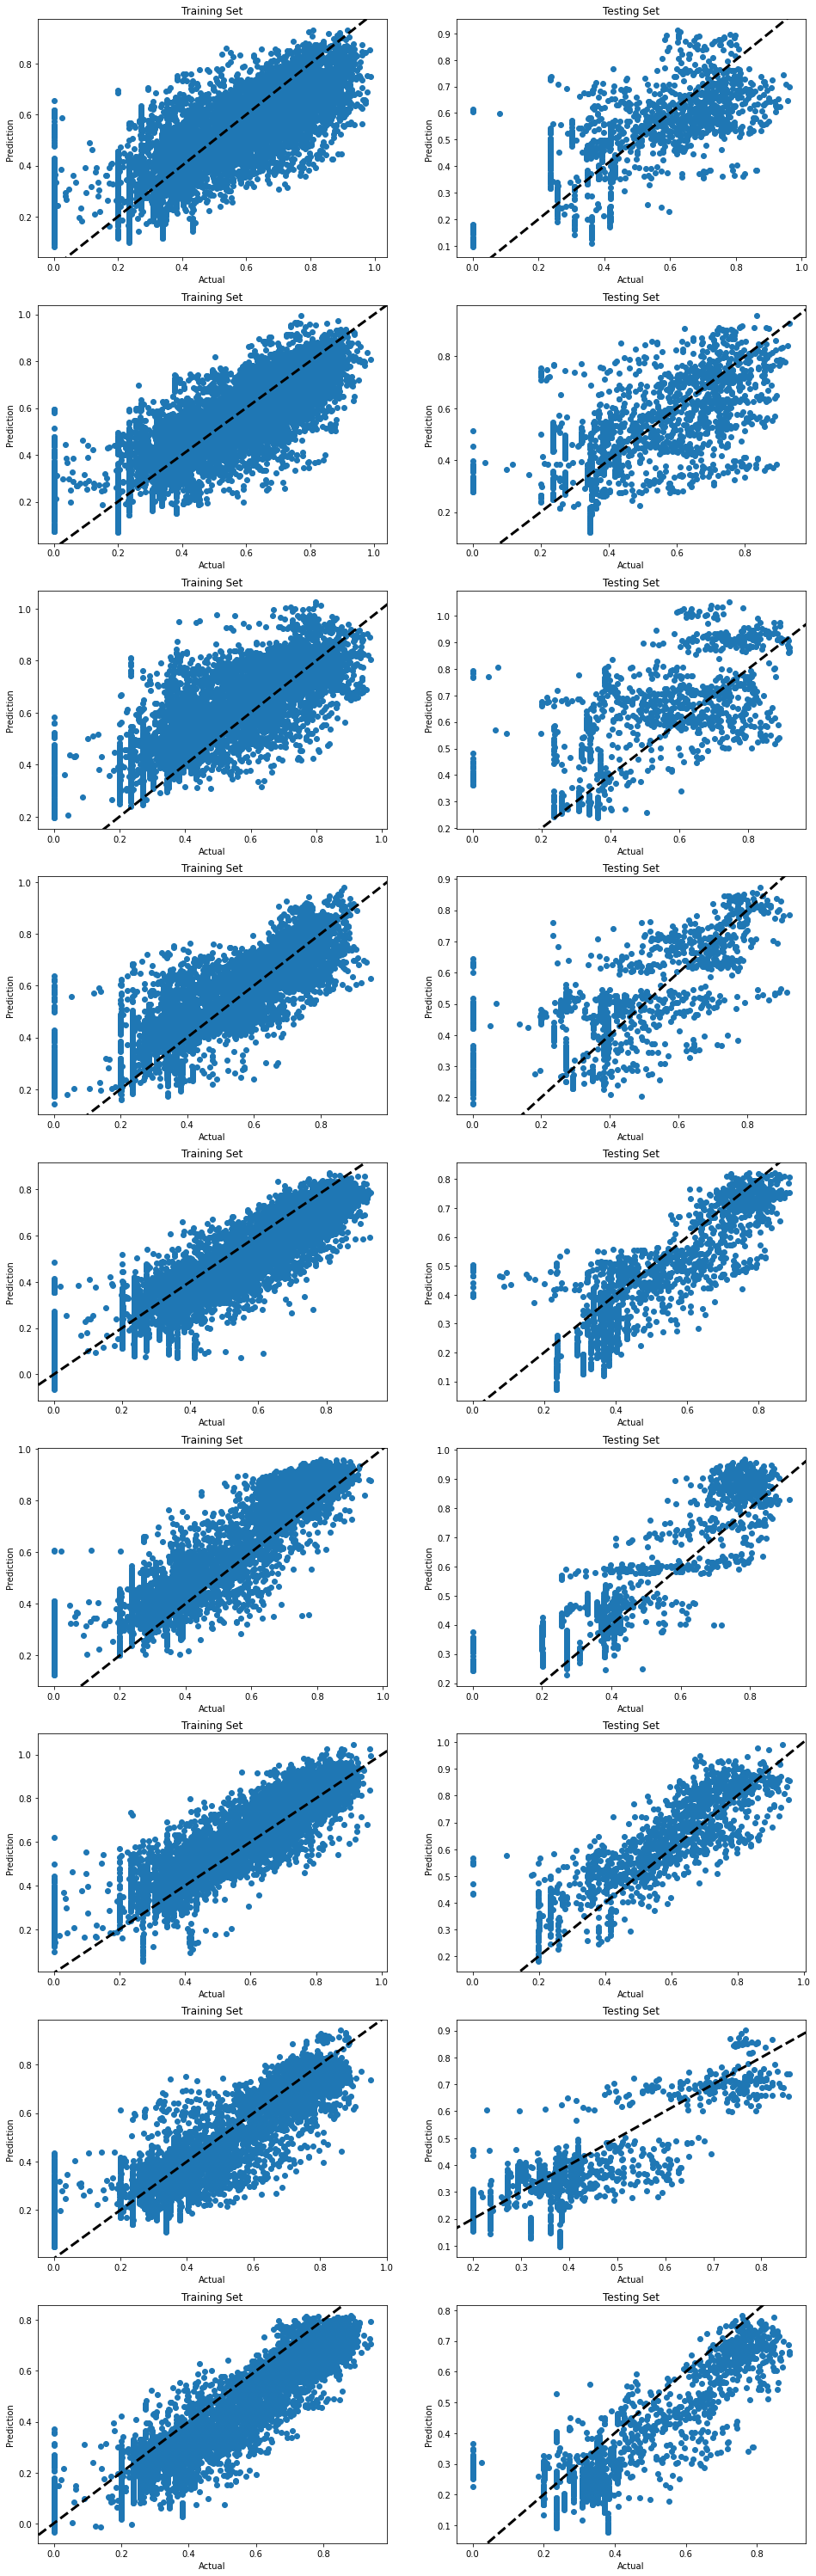

In [ ]:
plt.rcParams["figure.figsize"] = (16,54)
fig, ax = plt.subplots(len(selected_grids_daily), 2)
for i in range(len(selected_grids_daily)):
    ax[i,0].scatter(pred_train[i][0][:,:,:,0].reshape(pred_train[i][0][:,:,:,0].shape[0], -1), 
                    pred_train[i][1][:,:,:,0].reshape(pred_train[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # min of both axes
        np.max([ax[i,0].get_xlim(), ax[i,0].get_ylim()]),  # max of both axes
    ]
    ax[i,0].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,0].set_title("Training Set")
    ax[i,0].set_xlabel("Actual")
    ax[i,0].set_ylabel("Prediction")
    ax[i,1].scatter(pred_test[i][0][:,:,:,0].reshape(pred_test[i][0][:,:,:,0].shape[0], -1), 
                    pred_test[i][1][:,:,:,0].reshape(pred_test[i][1][:,:,:,0].shape[0], -1), marker='o')
    lims = [
        np.min([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # min of both axes
        np.max([ax[i,1].get_xlim(), ax[i,1].get_ylim()]),  # max of both axes
    ]
    ax[i,1].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[i,1].set_title("Testing Set")
    ax[i,1].set_xlabel("Actual")
    ax[i,1].set_ylabel("Prediction")

In [ ]:
## Monthly model no fire features
prec_monthly_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = False, mode = "monthly", logit = False,
                                                                        learning_rate = 0.0001, epoch = 40, batch_size = 4)

In [ ]:
print("MAE: " + str(mean_absolute_error(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))
print("MAPE: " + str(mean_absolute_percentage_error(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))
print("R-squared: " + str(r2_score(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
          (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
          np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))

MAE: 0.4688161
MAPE: 0.043094475
R-squared: 0.913160135281894


In [ ]:
for n in range(len(selected_grids_monthly))):
    print("MAE: " + str(mean_absolute_error(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("MAPE: " + str(mean_absolute_percentage_error(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])))))
    print("R-squared: " + str(r2_score(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])))))
    print("\n")

MAE: 0.46853116
MAPE: 0.0400737
R-squared: 0.504531326119196


MAE: 0.390158
MAPE: 0.032721978
R-squared: 0.7860840392737948


MAE: 0.45714927
MAPE: 0.043230522
R-squared: 0.9469418299284427


MAE: 0.5835327
MAPE: 0.05762555
R-squared: 0.8968800396418636


MAE: 0.44538882
MAPE: 0.041925382
R-squared: 0.9037242783714715




In [ ]:
print("MAE: " + str(mean_absolute_error(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))
print("MAPE: " + str(mean_absolute_percentage_error(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))
print("R-squared: " + str(r2_score(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
          (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
          np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))

MAE: 0.55380136
MAPE: 0.05108851
R-squared: 0.8612403456680109


In [ ]:
for n in range(len(selected_grids_monthly)):
    print("MAE: " + str(mean_absolute_error(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("MAPE: " + str(mean_absolute_percentage_error(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("R-squared: " + str(r2_score(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("\n")

MAE: 0.4700663
MAPE: 0.040457558
R-squared: 0.435122163065092


MAE: 0.45051894
MAPE: 0.03889455
R-squared: 0.6991174505822612


MAE: 0.6158842
MAPE: 0.058998406
R-squared: 0.8849979022302167


MAE: 0.71937114
MAPE: 0.06936289
R-squared: 0.8021320721326413


MAE: 0.5104068
MAPE: 0.047275335
R-squared: 0.8718458756137873




In [ ]:
## Monthly model with existence of fire features
prec_monthly_model, pred_train, pred_test = train_predict_precipitation(is_wildfire_features = True, mode = "monthly", logit = False,
                                                                        learning_rate = 0.0001, epoch = 80, batch_size = 4)

In [ ]:
print("MAE: " + str(mean_absolute_error(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))
print("MAPE: " + str(mean_absolute_percentage_error(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))
print("R-squared: " + str(r2_score(
    100 * ((np.exp(train_y.reshape(train_y.shape[0], -1)) - 1e-5) * \
          (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
          np.min(era5_land_monthly_scaled['precipitation']), 
    100 * ((np.exp(pred_train.reshape(pred_train.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation']))))))

MAE: 0.4808095
MAPE: 0.044186812
R-squared: 0.9089509235631776


In [ ]:
for n in range(len(selected_grids_monthly)):
    print("MAE: " + str(mean_absolute_error(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("MAPE: " + str(mean_absolute_percentage_error(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])))))
    print("R-squared: " + str(r2_score(
        100 * ((np.exp(train_y[n].reshape(train_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_train[n].reshape(pred_train[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])))))
    print("\n")

MAE: 0.47669786
MAPE: 0.040054686
R-squared: 0.504116409860215


MAE: 0.36357757
MAPE: 0.030558296
R-squared: 0.8030748965538249


MAE: 0.5118504
MAPE: 0.04888473
R-squared: 0.936728907463565


MAE: 0.5740539
MAPE: 0.056877606
R-squared: 0.8954635550518626


MAE: 0.47552255
MAPE: 0.04417523
R-squared: 0.8955866690055871




In [ ]:
print("MAE: " + str(mean_absolute_error(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))
print("MAPE: " + str(mean_absolute_percentage_error(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))
print("R-squared: " + str(r2_score(
    100 * ((np.exp(test_y.reshape(test_y.shape[0], -1)) - 1e-5) * \
          (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
          np.min(era5_land_monthly_scaled['precipitation'])), 
    100 * ((np.exp(pred_test.reshape(pred_test.shape[0], -1)) - 1e-5) * \
            (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
            np.min(era5_land_monthly_scaled['precipitation'])))))

MAE: 0.550181
MAPE: 0.050700594
R-squared: 0.8667190460908665


In [ ]:
for n in range(len(selected_grids_monthly)):
    print("MAE: " + str(mean_absolute_error(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("MAPE: " + str(mean_absolute_percentage_error(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("R-squared: " + str(r2_score(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation']))))
    print("\n")

MAE: 0.48001876
MAPE: 0.04076212
R-squared: 0.4270019951892287


MAE: 0.39881283
MAPE: 0.03500255
R-squared: 0.750599392850003


MAE: 0.60409623
MAPE: 0.057924695
R-squared: 0.8941989959422605


MAE: 0.7130381
MAPE: 0.0691273
R-squared: 0.8063896835354645


MAE: 0.55255574
MAPE: 0.05029671
R-squared: 0.8568942395202707




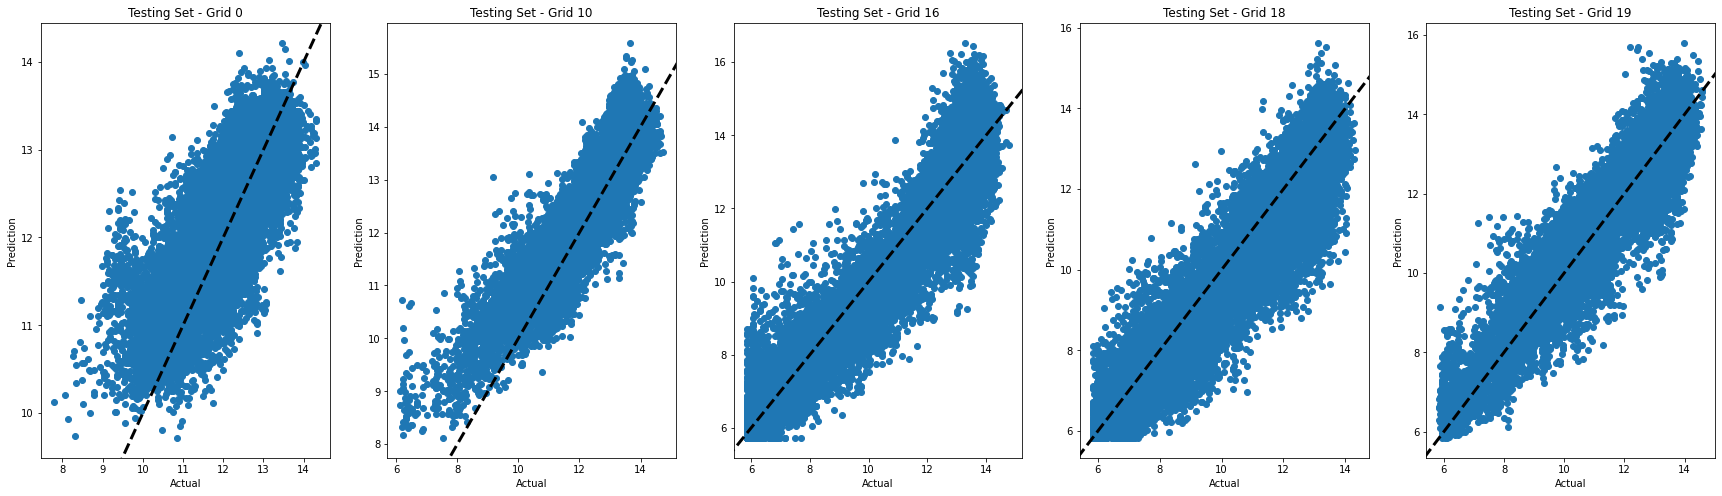

In [ ]:
plt.rcParams["figure.figsize"] = (30,8)
fig, ax = plt.subplots(1, 5)
for n in range(len(selected_grids_monthly)):
    ax[n].scatter(
        100 * ((np.exp(test_y[n].reshape(test_y[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        100 * ((np.exp(pred_test[n].reshape(pred_test[n].shape[0], -1)) - 1e-5) * \
               (np.max(era5_land_monthly_scaled['precipitation']) - np.min(era5_land_monthly_scaled['precipitation'])) + \
               np.min(era5_land_monthly_scaled['precipitation'])), 
        marker='o')
    lims = [
        np.min([ax[n].get_xlim(), ax[n].get_ylim()]),  # min of both axes
        np.max([ax[n].get_xlim(), ax[n].get_ylim()]),  # max of both axes
    ]
    ax[n].plot(lims, lims, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    ax[n].set_title("Testing Set - " + "Grid " + str(selected_grids[n]))
    ax[n].set_xlabel("Actual")
    ax[n].set_ylabel("Prediction")